In [2]:
import sys, os, pygmt, importlib
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_processor          import SeaIceProcessor
from sea_ice_plotter            import SeaIcePlotter
from grounded_iceberg_processor import GroundedIcebergProcessor
from datetime                   import timedelta, date, datetime
from pathlib                    import Path
from dask.distributed           import Client, LocalCluster
import numpy                    as np
import pandas                   as pd
import xarray                   as xr
# import xesmf                    as xe
# import matplotlib.pyplot        as plt
# import matplotlib.dates         as mdates

In [36]:
# Import module *objects* first
import sea_ice_processor
import sea_ice_plotter
import grounded_iceberg_processor
# Reload them if they were edited
importlib.reload(sea_ice_processor)
importlib.reload(sea_ice_plotter)
importlib.reload(grounded_iceberg_processor)
# Then (re)import the classes from the reloaded modules
from sea_ice_processor          import SeaIceProcessor
from sea_ice_plotter            import SeaIcePlotter
from grounded_iceberg_processor import GroundedIcebergProcessor

# grounded icebergs

In [ ]:
GI_proc = GroundedIcebergProcessor()
GI_proc.process_raw_grounded_iceberg_database()
GI_proc.modify_landmask_with_grounded_icebergs(p_min=0.1, p_max=0.9, scaling_exponent=.35)

In [ ]:
GI_proc.write_modified_landmask_and_counts_to_disk(write=True, overwrite=True)

In [ ]:
SP = SeaIcePlotter(ice_type='GI', sim_name='baseline', show_fig = True, save_fig = True, )
KMT1 = xr.open_dataset("/g/data/gv90/da1339/grounded_icebergs/MyThin_db/kmt_mod_thinned-0p75_v1p50_POSSIBLE_ERROR.nc")
KMT2 = xr.open_dataset("/g/data/gv90/da1339/grounded_icebergs/MyThin_db/kmt_mod_thinned-0p75_v1p50.nc")
SP.plot_sectors_grounded_icebergs(KMT2=KMT2,save_dir="0p25", filename_extras="POSSIBLE-ERRORS_v_Revised")

In [ ]:
P_kmt_mod = "/g/data/gv90/da1339/grounded_icebergs/MyThin_db/kmt_mod_thinned-0p75_v1p50.nc"
P_kmt_org = "/g/data/gv90/da1339/grounded_icebergs/MyThin_db/KMT_original_reformatted_with_coordinates.nc"
ds_mod    = xr.open_dataset(P_kmt_mod)
ds_org    = xr.open_dataset(P_kmt_org)
kmt_mod   = ds_mod['kmt'].values
kmt_org   = ds_org['kmt'].values
lat       = ds_mod['lat']
lon       = ds_mod['lon']
dlon      = np.mean(np.diff(lon.values[0]))  # assumes regular grid in ni dimension
print("MOD KMT LAND CELL COUNT:", np.sum(kmt_mod == 1))
print("ORG KMT LAND CELL COUNT:", np.sum(kmt_org == 1))
print("Total mismatches:", np.sum(kmt_mod != kmt_org))
print("Unique values in KMT MODIFIED:", np.unique(kmt_mod))
print("Unique values in KMT ORIGINAL:", np.unique(kmt_org))
assert kmt_mod.shape == kmt_org.shape == lat.shape == lon.shape
# Get indices of mismatch
mask_diff = (kmt_org==1) & (kmt_mod!=1)
ji_diff = np.where(mask_diff)  # ji_diff = (j indices, i indices)
# Shift i (longitude) index one cell west
j_idx, i_idx = ji_diff
i_idx_shifted = i_idx - 1  # move one cell west
# Remove invalid (negative) i indices
valid_mask = i_idx_shifted >= 0
j_idx = j_idx[valid_mask]
i_idx = i_idx_shifted[valid_mask]
# Extract adjusted coordinates
lat_diff = lat.values[j_idx, i_idx]
lon_diff = lon.values[j_idx, i_idx]

In [ ]:
KMT_mod = 

# process for fast ice using SeaIceProcessor()

In [ ]:
cluster = LocalCluster(n_workers=28, threads_per_worker=1, memory_limit='6GB')
client = Client(cluster)
print("✅ Dask dashboard:", client.dashboard_link)

In [37]:
sim_name  = "ry93"
ispd_thresh = 5.0e-4
ice_type    = "FI_BT"
ispd_str = f"{ispd_thresh:.1e}".replace("e-0", "e-")
SI_proc  = SeaIceProcessor(sim_name = sim_name)
SI_plot  = SeaIcePlotter(sim_name  = sim_name,
                         ice_type  ='FI', 
                         plot_type = 'timeseries',
                         var_name  = 'FIA',
                         show_fig  = False,
                         save_fig  = True,
                         overwrite = True)
dt0_str, dtN_str = SI_proc.sim_config['dt0_str'], SI_proc.sim_config['dtN_str']
dt_range_str     = f"{dt0_str[:4]}-{dtN_str[:4]}"
cfg              = SI_proc.sim_config
ktens, elps, GI_thin = cfg.get("Ktens", "?"), cfg.get("e_f", "?"), 1 - cfg.get("GI_thin_fact", 0)
ice_types = [ice_type] if isinstance(ice_type, str) else list(ice_type)
D_out = Path(SI_proc.config['D_dict']['AFIM_out'], sim_name, "zarr", f"ispd_thresh_{ispd_str}", "ice_metrics")
D_out.mkdir(parents=True, exist_ok=True)
FIA_comp, FIP_comp = {}, {}
obs_clim = None
af2020_df = pd.read_csv(SI_proc.sea_ice_dict['P_AF2020_cli_csv'])
obs_clim  = SI_proc.interpolate_obs_fia(af2020_df)

2025-05-28 13:20:28,366 - INFO - hemisphere initialised: south
INFO:ry93:hemisphere initialised: south


333 circumpolar grounded icebergs associated with ry93
38098814849.39 m^2 total circumpolar grounded iceberg area for ry93
333 circumpolar grounded icebergs associated with ry93
38098814849.39 m^2 total circumpolar grounded iceberg area for ry93


In [34]:
CICE_SO
#DS_FI, CICE_SO = SI_proc.load_processed_cice(dt0_str     = dt0_str,
                                             # dtN_str     = dtN_str,
                                             # ispd_thresh = ispd_thresh,
                                             # ice_type    = "FI_BT",
                                             # load_original_CICE = True,
                                             # rolling     = False,
                                             # chunks      = {"time": 10})

<xarray.Dataset> Size: 135GB
Dimensions:   (time: 2556, nj: 540, ni: 1440)
Coordinates:
  * time      (time) datetime64[ns] 20kB 1993-01-02 1993-01-03 ... 2000-01-01
    TLON      (nj, ni) float32 3MB dask.array<chunksize=(540, 1440), meta=np.ndarray>
    TLAT      (nj, ni) float32 3MB dask.array<chunksize=(540, 1440), meta=np.ndarray>
    ULON      (nj, ni) float32 3MB dask.array<chunksize=(540, 1440), meta=np.ndarray>
    ULAT      (nj, ni) float32 3MB dask.array<chunksize=(540, 1440), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Data variables: (12/17)
    aice      (time, nj, ni) float32 8GB dask.array<chunksize=(1, 540, 1440), meta=np.ndarray>
    uvel      (time, nj, ni) float32 8GB dask.array<chunksize=(1, 540, 1440), meta=np.ndarray>
    vvel      (time, nj, ni) float32 8GB dask.array<chunksize=(1, 540, 1440), meta=np.ndarray>
    hi        (time, nj, ni) float32 8GB dask.array<chunksize=(1, 540, 1440), meta=np.ndarray>
    tarea     (time, nj, ni) float32 8GB dask.array<chunksize=(1, 540, 1440), meta=np.ndarray>
    uarea     (time, nj, ni) float32 8GB dask.array<chunksize=(1, 540, 1440), meta=np.ndarray>
    ...        ...
    iage      (time, nj, ni) float32 8GB dask.array<chunksize=(1, 540, 1440), meta=np.ndarray>
    divu      (time, nj, ni) float32 8GB dask.array<chunksize=(1, 540, 1440), meta=np.ndarray>
    daidtd    (time, nj, ni) float32 8GB dask.array<chunksize=(1, 540, 1440), meta=np.ndarray>
    daidtt    (time, nj, ni) float32 8GB dask.array<chunksize=(1, 540, 1440), meta=np.ndarray>
    dvidtd    (time, nj, ni) float32 8GB dask.array<chunksize=(1, 540, 1440), meta=np.ndarray>
    dvidtt    (time, nj, ni) float32 8GB dask.array<chunksize=(1, 540, 1440), meta=np.ndarray>
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       Los Alamos Sea Ice Model, CICE_6.4.0
    comment:      This year has 365 days
    comment2:     File written on model date 19930102
    comment3:     seconds elapsed into model date:      0
    conventions:  CF-1.0
    history:      This dataset was created on 2025-05-08 at 11:04:48.6
    io_flavor:    io_netcdf

In [38]:
METS = {}
# basic spatial and temporal statistics: ice area , ice persistence
FIA                  = SI_proc.compute_ice_area(DS_FI['aice'], DS_FI['tarea']).compute()
FIP                  = SI_proc.compute_variable_aggregate(DS_FI['aice']).compute()
METS['FIA']          = FIA
METS['FIP']          = FIP
# Growth METS
METS["onset_doy"]    = SI_proc.compute_fia_onset_doy(FIA)
METS["growth_rate"]  = SI_proc.compute_fia_growth_rate(FIA)
METS["max_growth"]   = SI_proc.compute_fia_max_growth(FIA)
# Seasonality METS
METS["doy_max"]      = SI_proc.compute_doy_max(FIA)
METS["duration"]     = SI_proc.compute_fast_ice_duration(FIA)
# Stability METS
fip_mean, fip_std    = SI_proc.compute_fip_spatial_stats(FIP)
METS["FIP_mean"]     = fip_mean
METS["FIP_std"]      = fip_std
mean_dist, max_dist  = SI_proc.compute_fast_ice_distance_extent(DS_FI['FI_mask'])
METS["mean_FI_dist"] = mean_dist
METS["max_FI_dist"]  = max_dist

2025-05-28 13:20:31,753 - INFO - 🧮 Spatially-integrating the product of sea ice concentrations and grid cell areas
INFO:ry93:🧮 Spatially-integrating the product of sea ice concentrations and grid cell areas


In [39]:
METS

{'FIA': <xarray.DataArray (time: 2556)> Size: 20kB
 array([ 38.18980471,  38.09881485,  38.09881485, ..., 327.34729203,
        340.16354496, 330.55701594])
 Coordinates:
   * time     (time) datetime64[ns] 20kB 1993-01-02 1993-01-03 ... 2000-01-01,
 'FIP': <xarray.DataArray 'aice' (nj: 540, ni: 1440)> Size: 3MB
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
 Coordinates:
     TLAT     (nj, ni) float32 3MB -81.08 -81.08 -81.08 ... 10.32 10.32 10.32
     TLON     (nj, ni) float32 3MB 79.88 80.12 80.38 80.62 ... 79.12 79.38 79.62
     ULAT     (nj, ni) float32 3MB -81.02 -81.02 -81.02 ... 10.44 10.44 10.44
     ULON     (nj, ni) float32 3MB -280.0 -279.8 -279.5 ... 79.25 79.5 79.75
   * ni       (ni) int64 12kB 0 1 2 3 4 5 6 ... 1434 1435 1436 1437 1438 1439
   * nj       (nj

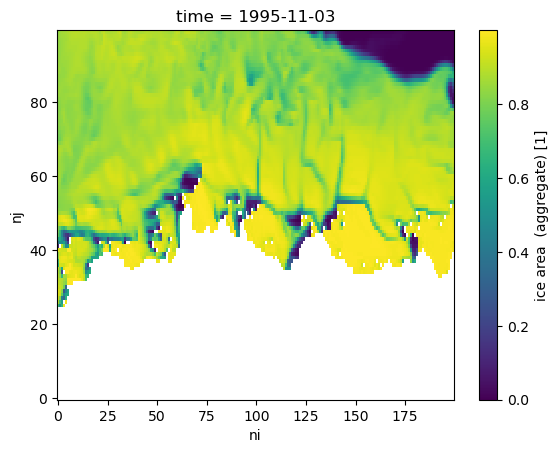

In [50]:
ds = xr.open_zarr( "/g/data/gv90/da1339/afim_output/ry93/zarr/iceh_1995-11.zarr" )
ds['aice'].isel(time=1,nj=slice(100,200),ni=slice(0,200)).plot()

In [ ]:
from pyproj import CRS, Transformer
D_obs  = Path(SI_proc.sea_ice_dict['D_AF2020_db_org'])
P_orgs = sorted(D_obs.glob("FastIce_70_*.nc"))
ds_all = xr.open_mfdataset(P_orgs, engine='netcdf4')
crs_obs          = CRS.from_epsg(SI_proc.sea_ice_dict["projection_FI_obs"]) #unique to observations
crs_spherical    = CRS.from_epsg(SI_proc.sea_ice_dict["projection_wgs84"])  #spherical coordinates
transformer      = Transformer.from_crs(crs_obs, crs_spherical, always_xy=True)
X, Y             = np.meshgrid(ds_all['x'].isel(time=0).values, ds_all['y'].isel(time=0).values)
lon_obs, lat_obs = transformer.transform(X,Y)
G_obs       = SI_proc.GI_proc.build_grid_dict(lat_obs, lon_obs)
print(G_obs)

In [ ]:
G_obs       = xr.Dataset(G_obs)
print(G_obs)

In [ ]:
G_t           = xr.Dataset()
G_t['lat']    = SI_proc.GI_proc.G_t['lat']
G_t['lon']    = SI_proc.GI_proc.G_t['lon']
G_t['lat_b']  = SI_proc.GI_proc.G_t['lat_b']
G_t['lon_b']  = SI_proc.GI_proc.G_t['lon_b']
G_t["mask"]   = SI_proc.GI_proc.G_t['kmt_mod']
print(G_t)

In [ ]:
sim_name       = "ry93"
ispd_thresh    = 5e-4
ispd_str       = f"{ispd_thresh:.1e}".replace("e-0", "e-") 
dt0_str        = "1993-01-01" 
dtN_str        = "1999-12-31"
overwrite_zarr = False
overwrite_png  = True
compute_boolean= True
smooth_FIA_days= 15
fi_types       = ["FI_Ta","FI_BT"]
SI_proc        = SeaIceProcessor(sim_name=sim_name)
SI_plot        = SeaIcePlotter(sim_name  = sim_name,
                                ice_type  ='FI', 
                                plot_type = 'timeseries',
                                var_name  = 'FIA',
                                show_fig  = False,
                                save_fig  = True,
                                overwrite = True)

FIA_comp       = {}
FIP_comp       = {}
D_mets         = Path(SI_proc.config['D_dict']['AFIM_out'], sim_name, "zarr", f"ispd_thresh_{ispd_str}", "ice_metrics")
dt_range_str   = f"{dt0_str[:4]}-{dtN_str[:4]}"
cfg            = SI_proc.sim_config
ktens, elps, GI_thin = cfg.get("Ktens", "?"), cfg.get("e_f", "?"), 1 - cfg.get("GI_thin_fact", 0)
#SI_proc.process_daily_cice( dt0_str=dt0_str, dtN_str=dtN_str , ispd_thresh=ispd_thresh )
#SI_proc.process_rolling_cice( dt0_str=dt0_str, dtN_str=dtN_str , ispd_thresh=ispd_thresh )

In [ ]:
def plot_cice_field(x1, y1, z1, title, region, 
                    cmap="cmocean/haline", cmap_series=[0.9, 1],
                    GI_coords=None, GI_color="red", 
                    var_style="s0.5c", GI_style="c0.3c", 
                    projection="S75/-90/30c", 
                    cbar_label="sea ice concentration", units="1/100"):
    fig = pygmt.Figure()
    pygmt.config(FORMAT_GEO_MAP="ddd.x", FONT_TITLE="16p,Courier-Bold", FONT_ANNOT_PRIMARY="14p,Helvetica")
    pygmt.makecpt(cmap=cmap, series=cmap_series)
    fig.basemap(projection=projection, region=region, frame=["af", f"+t{title}"])
    fig.plot(x=x1, y=y1, fill=z1, cmap=True, style=var_style)
    if GI_coords:
        fig.plot(x=GI_coords[0], y=GI_coords[1], fill=GI_color, style=GI_style)
    fig.coast(land='gray')
    fig.colorbar(position="JBC+o0c/1.5c", frame=[f"x+l{cbar_label}", f"y+l{units}"])
    return fig

def plot_persistence_map(DA, sim_name, itype, ispd_str, ktens, elps, GI_thin, SI_plot, dt_range_str, overwrite_png):
    da   = DA.values.ravel()
    lon  = DA["TLON"].values.ravel()
    lat  = DA["TLAT"].values.ravel()
    mask = ~np.isnan(da)
    lat_plt, lon_plt, da_plt = lat[mask], lon[mask], da[mask]
    for reg_name, reg_cfg in SI_plot.reg_dict.items():
        D_plt = Path(SI_plot.D_graph, sim_name, reg_name, "FIP", f"ispd_thresh_{ispd_str}", itype)
        D_plt.mkdir(parents=True, exist_ok=True)
        P_plt = Path(D_plt,f"FIP_{dt_range_str}.png")
        if P_plt.exists() and not overwrite_png:
            print(f"figure {P_plt} exists and not overwriting")
            continue
        else:
            MC  = SI_plot.get_meridian_center_from_geographic_extent(reg_cfg['plt_ext'])
            fig = plot_cice_field(lon_plt, lat_plt, da_plt,
                                  f"{sim_name} {itype} ispd_thresh={ispd_str}: ktens={ktens}, elps={elps}, GI-thin={GI_thin:.2f}",
                                  region=reg_cfg['plt_ext'],
                                  cmap="/home/581/da1339/graphical/CPTs/AF2020_YlGnBu.cpt",
                                  cmap_series=[0, 1],
                                  GI_coords=(SI_plot.GI_proc.G_t['GI_lon'], SI_plot.GI_proc.G_t['GI_lat']),
                                  GI_color="red", var_style="s0.3c", GI_style="c0.1c", 
                                  projection=f"S{MC}/-90/30c", cbar_label="fast ice persistence")
            print(f"📸 Saving figure: {P_plt}")
            fig.savefig(P_plt)
            

In [ ]:
SO = SI_proc.load_processed_cice(dt0_str=dt0_str,
                                   dtN_str=dtN_str,
                                   ispd_thresh=ispd_thresh,
                                   rolling=False,
                                   ice_type="SO",
                                   chunks={"time": 10})
for itype in fi_types:
    for roll in [False,True]:
        i_type = f"{itype}_roll" if roll else itype
        P_FIA  = Path(D_mets,f"FIA_{i_type}.zarr")
        P_FIP  = Path(D_mets,f"FIP_{i_type}.zarr")
        if P_FIA.exists() and P_FIP.exists() and not overwrite_zarr:
            print(f"{P_FIA} exists and not overwriting--loading")
            print(f"{P_FIP} exists and not overwriting--loading")
            FIA = xr.open_zarr(P_FIA).to_array().squeeze()
            FIP = xr.open_zarr(P_FIP).aice    
        else:
            print(f"{P_FIA} does NOT exists and/or overwriting--computing")
            print(f"{P_FIP} does NOT exists and/or overwriting--computing")
            ds = SI_proc.load_processed_cice(dt0_str     = dt0_str,
                                             dtN_str     = dtN_str,
                                             ispd_thresh = ispd_thresh,
                                             ice_type    = itype,
                                             rolling     = roll,
                                             chunks      = {"time": 10})
            if ds is None: continue
            FIA = SI_proc.compute_ice_area(ds['aice'], ds['tarea']).compute()
            FIP = SI_proc.compute_variable_aggregate(ds['aice']).compute()
            FIA.to_zarr(P_FIA, mode="w", consolidated=True)
            FIP.to_zarr(P_FIP, mode="w", consolidated=True)
        FIA_comp[i_type] = FIA
        FIP_comp[i_type] = FIP
        plot_persistence_map(FIP, sim_name, i_type, ispd_str, ktens, elps, GI_thin, SI_plot, dt_range_str, overwrite_png)
        if compute_boolean and not roll:
            i_type    = f"{itype}_bool"
            P_FIA     = Path(D_mets,f"FIA_{i_type}.zarr")
            P_FIP     = Path(D_mets,f"FIP_{i_type}.zarr")
            if P_FIA.exists() and P_FIP.exists() and not overwrite_zarr:
                print(f"{P_FIA} exists and not overwriting--loading")
                print(f"{P_FIP} exists and not overwriting--loading")
                FIA_b = xr.open_zarr(P_FIA).to_array().squeeze()
                FIP_b = xr.open_zarr(P_FIP).aice
            else:
                print(f"{P_FIA} does NOT exists and/or overwriting--computing")
                print(f"{P_FIP} does NOT exists and/or overwriting--computing")
                bool_mask = SI_proc.boolean_fast_ice(ds['FI_mask'], dim="time", window=7, min_count=6)
                ds_bool   = SO.where(bool_mask)
                FIA_b     = SI_proc.compute_ice_area(ds_bool['aice'], ds_bool['tarea']).compute()
                FIP_b     = SI_proc.compute_variable_aggregate(ds_bool['aice']).compute()
                FIA_b.to_zarr(P_FIA, mode="w", consolidated=True)
                FIP_b.to_zarr(P_FIP, mode="w", consolidated=True)
            FIA_comp[i_type] = FIA_b
            FIP_comp[i_type] = FIP_b
            plot_persistence_map(FIP_b, sim_name, i_type, ispd_str, ktens, elps, GI_thin, SI_plot, dt_range_str, overwrite_png)
tit_str = f"{sim_name} ispd_thresh={ispd_str}: ktens={ktens}, elps={elps}, GI-thin={GI_thin:.2f}"
if smooth_FIA_days>0:
    P_png = Path(SI_plot.D_graph, "timeseries", f"FIA_{sim_name}_{ispd_str}_smoothed_{dt_range_str}.png")
else:
    P_png = Path(SI_plot.D_graph, "timeseries", f"FIA_{sim_name}_{ispd_str}_{dt_range_str}.png")
if P_png.exists and not overwrite_png:
    print(f"{P_png} exists and not overwriting")
else:
    print(f"{P_png} does NOT exists and/or overwriting--creating")
    SI_plot.plot_ice_area(FIA_comp, tit_str=tit_str, P_png=P_png, roll_days=smooth_FIA_days)
    

In [ ]:
SI_plot.plot_ice_area(FIA_comp, tit_str=tit_str, P_png=P_png, roll_days=smooth_FIA_days)

In [ ]:
FI_B_bool_mask  = SI_proc.boolean_fast_ice(FI_B['FI_mask'], dim="time", window=7, min_count=6)
FI_Ta_bool_mask = SI_proc.boolean_fast_ice(FI_Ta['FI_mask'], dim="time", window=7, min_count=6)
FI_Tx_bool_mask = SI_proc.boolean_fast_ice(FI_Tx['FI_mask'], dim="time", window=7, min_count=6)
FI_BT_bool_mask = SI_proc.boolean_fast_ice(FI_BT['FI_mask'], dim="time", window=7, min_count=6)
FI_B_bool       = SO.where(FI_B_bool_mask)
FI_Ta_bool      = SO.where(FI_Ta_bool_mask)
FI_Tx_bool      = SO.where(FI_Tx_bool_mask)
FI_BT_bool      = SO.where(FI_BT_bool_mask)

In [ ]:
nj_slice = slice(143,148)#slice(139,144)
ni_slice = slice(47,53)#slice(45,50)
style    = "s3c"
SO_slice = SO.sel(time=slice("1998-09-20","1998-10-10")).isel(nj=nj_slice,ni=ni_slice)
SO_roll_slice = SO_roll.sel(time=slice("1998-09-20","1998-10-10")).isel(nj=nj_slice,ni=ni_slice)
#FI_Ta_njni_slice = FI_Ta.isel(nj=nj_slice,ni=ni_slice)
#FI_Ta_roll_njni_slice = FI_Ta_roll.isel(nj=nj_slice,ni=ni_slice)
#FI_Ta_bool_njni_slice = FI_Ta_bool.isel(nj=nj_slice,ni=ni_slice)
for i, dt in enumerate(SO_slice.time.values):
    dt_str  = pd.to_datetime(dt - 1).strftime('%Y-%m-%d')
    #FI_Ta_t = FI_Ta_njni_slice.isel(time=i)
    SO_t      = SO_slice.isel(time=i)
    SO_roll_t = SO_roll_slice.isel(time=i)
    # FI_Ta_roll_t = FI_Ta_roll_njni_slice.isel(time=i)
    # FI_Ta_bool_t = FI_Ta_bool_njni_slice.isel(time=i)
    # df_Ta = dataarray_to_df(FI_Ta_t, varname="ispd_Ta")
    # df_Ta_roll = dataarray_to_df(FI_Ta_roll_t, varname="ispd_Ta")
    # df_Ta_bool = dataarray_to_df(FI_Ta_bool_t, varname="ispd_Ta")
    # print(df_Ta_bool)
    ispd_B_da = SO_t['ispd_B']#.astype("float32")  # select variable and cast
    mask      = np.isfinite(ispd_B_da.values)
    df_B      = {"lon": ispd_B_da["ULON"].values[mask],
                  "lat": ispd_B_da["ULAT"].values[mask],
                  "val": ispd_B_da.values[mask]}
    ispd_B_roll_da = SO_roll_t['ispd_B']#.astype("float32")  # select variable and cast
    mask           = np.isfinite(ispd_B_roll_da.values)
    df_B_roll      = {"lon": ispd_B_roll_da["ULON"].values[mask],
                      "lat": ispd_B_roll_da["ULAT"].values[mask],
                     "val": ispd_B_roll_da.values[mask]}
    ispd_Ta_da = SO_t['ispd_Ta']#.astype("float32")  # select variable and cast
    mask       = np.isfinite(ispd_Ta_da.values)
    df_Ta      = {"lon": ispd_Ta_da["TLON"].values[mask],
                  "lat": ispd_Ta_da["TLAT"].values[mask],
                  "val": ispd_Ta_da.values[mask]}
    ispd_Ta_roll_da = SO_roll_t['ispd_Ta']#.astype("float32")  # select variable and cast
    mask            = np.isfinite(ispd_Ta_roll_da.values)
    df_Ta_roll      = {"lon": ispd_Ta_roll_da["TLON"].values[mask],
                      "lat": ispd_Ta_roll_da["TLAT"].values[mask],
                      "val": ispd_Ta_roll_da.values[mask]}
    ispd_Tx_da = SO_t['ispd_Tx']#.astype("float32")  # select variable and cast
    mask       = np.isfinite(ispd_Tx_da.values)
    df_Tx      = {"lon": ispd_Tx_da["TLON"].values[mask],
                  "lat": ispd_Tx_da["TLAT"].values[mask],
                  "val": ispd_Tx_da.values[mask]}
    ispd_Tx_roll_da = SO_roll_t['ispd_Tx']#.astype("float32")  # select variable and cast
    mask            = np.isfinite(ispd_Tx_roll_da.values)
    df_Tx_roll      = {"lon": ispd_Tx_roll_da["TLON"].values[mask],
                      "lat": ispd_Tx_roll_da["TLAT"].values[mask],
                      "val": ispd_Tx_roll_da.values[mask]}
    ispd_BT_da = SO_t['ispd_BT']#.astype("float32")  # select variable and cast
    mask       = np.isfinite(ispd_BT_da.values)
    df_BT      = {"lon": ispd_BT_da["TLON"].values[mask],
                  "lat": ispd_BT_da["TLAT"].values[mask],
                  "val": ispd_BT_da.values[mask]}
    ispd_BT_roll_da = SO_roll_t['ispd_BT']#.astype("float32")  # select variable and cast
    mask            = np.isfinite(ispd_BT_roll_da.values)
    df_BT_roll      = {"lon": ispd_BT_roll_da["TLON"].values[mask],
                      "lat": ispd_BT_roll_da["TLAT"].values[mask],
                      "val": ispd_BT_roll_da.values[mask]}
    region  = [float(SO_t.TLON.min()), float(SO_t.TLON.max()),
               float(SO_t.TLAT.min()), float(SO_t.TLAT.max())]
    print(f"{dt_str}:")
    print(f"\tispd_B :")
    for row in SO_t['ispd_B'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    print(f"\tispd_B_roll :")
    for row in SO_roll_t['ispd_B'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    print(f"\tispd_Ta :")
    for row in SO_t['ispd_Ta'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    print(f"\tispd_Ta_roll :")
    for row in SO_roll_t['ispd_Ta'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    print(f"\tispd_Tx :")
    for row in SO_t['ispd_Tx'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    print(f"\tispd_Tx_roll :")
    for row in SO_roll_t['ispd_Tx'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    print(f"\tispd_BT :")
    for row in SO_t['ispd_BT'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    print(f"\tispd_BT_roll :")
    for row in SO_roll_t['ispd_BT'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    #print(f"\tuvel : {np.array2string(SO_njni_slice['uvel'].isel(time=1).values, precision=5, suppress_small=False)}")
    print("\n")
    fig = pygmt.Figure()
    pygmt.makecpt(cmap="cmocean/speed", series=[0,ispd_thresh])
    with fig.subplot(nrows=8, ncols=1, figsize=("20c", "100c"), sharex="b", sharey="l", margins=["0.1c", "1c"], 
                     title=f"{dt_str}", autolabel=False): #ispd_B (top), ispd_Ta (mid), ispd_Ta_roll (bot)"):
        with fig.set_panel(panel=0):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_B"])
            fig.coast(land='gray')
            fig.plot(x=df_B["lon"], y=df_B["lat"], style=style, fill=df_B["val"], cmap=True)
        with fig.set_panel(panel=1):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_B_roll"])
            fig.coast(land='gray')
            fig.plot(x=df_B_roll["lon"], y=df_B_roll["lat"], style=style, fill=df_B_roll["val"], cmap=True)
        with fig.set_panel(panel=2):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_Ta"])
            fig.coast(land='gray')
            fig.plot(x=df_Ta["lon"], y=df_Ta["lat"], style=style, fill=df_Ta["val"], cmap=True)
        with fig.set_panel(panel=3):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_Ta_roll"])
            fig.coast(land='gray')
            fig.plot(x=df_Ta_roll["lon"], y=df_Ta_roll["lat"], style=style, fill=df_Ta_roll["val"], cmap=True)
        with fig.set_panel(panel=4):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_Tx"])
            fig.coast(land='gray')
            fig.plot(x=df_Tx["lon"], y=df_Tx["lat"], style=style, fill=df_Tx["val"], cmap=True)
        with fig.set_panel(panel=5):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_Tx_roll"])
            fig.coast(land='gray')
            fig.plot(x=df_Tx_roll["lon"], y=df_Tx_roll["lat"], style=style, fill=df_Tx_roll["val"], cmap=True)
        with fig.set_panel(panel=6):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_BT"])
            fig.coast(land='gray')
            fig.plot(x=df_BT["lon"], y=df_BT["lat"], style=style, fill=df_BT["val"], cmap=True)
        with fig.set_panel(panel=7):
            fig.basemap(region=region, projection="M?", frame=["af", f"+tispd_BT_roll"])
            fig.coast(land='gray')
            fig.plot(x=df_BT_roll["lon"], y=df_BT_roll["lat"], style=style, fill=df_BT_roll["val"], cmap=True)
        fig.colorbar(position="JBC+o0c/1.5c", frame=[f"x+lsea ice speed", f"y+lm/s"])
    fig.show()
    break

In [ ]:
FIA_comp               = {}
FIA_comp["FI_B"]       = SI_proc.compute_ice_area(FI_B['aice'],FI_B['tarea']).compute()
FIA_comp["FI_Ta"]      = SI_proc.compute_ice_area(FI_Ta['aice'],FI_Ta['tarea']).compute()
FIA_comp["FI_Tx"]      = SI_proc.compute_ice_area(FI_Tx['aice'],FI_Tx['tarea']).compute()
FIA_comp["FI_BT"]      = SI_proc.compute_ice_area(FI_BT['aice'],FI_BT['tarea']).compute()
FIA_comp["FI_B_roll"]  = SI_proc.compute_ice_area(FI_B_roll['aice'],FI_B_roll['tarea']).compute()
FIA_comp["FI_Ta_roll"] = SI_proc.compute_ice_area(FI_Ta_roll['aice'],FI_Ta_roll['tarea']).compute()
FIA_comp["FI_Tx_roll"] = SI_proc.compute_ice_area(FI_Tx_roll['aice'],FI_Tx_roll['tarea']).compute()
FIA_comp["FI_BT_roll"] = SI_proc.compute_ice_area(FI_BT_roll['aice'],FI_BT_roll['tarea']).compute()
FIA_comp["FI_B_bool"]  = SI_proc.compute_ice_area(FI_B_bool['aice'],FI_B_bool['tarea']).compute()
FIA_comp["FI_Ta_bool"] = SI_proc.compute_ice_area(FI_Ta_bool['aice'],FI_Ta_bool['tarea']).compute()
FIA_comp["FI_Tx_bool"] = SI_proc.compute_ice_area(FI_Tx_bool['aice'],FI_Tx_bool['tarea']).compute()
FIA_comp["FI_BT_bool"] = SI_proc.compute_ice_area(FI_BT_bool['aice'],FI_BT_bool['tarea']).compute()

In [ ]:
FI_Ta_roll

In [ ]:
FIP_comp               = {}
FIP_comp["FI_B"]       = SI_proc.compute_variable_aggregate(FI_B['aice']).compute()
FIP_comp["FI_Ta"]      = SI_proc.compute_variable_aggregate(FI_Ta['aice']).compute()
FIP_comp["FI_Tx"]      = SI_proc.compute_variable_aggregate(FI_Tx['aice']).compute()
FIP_comp["FI_BT"]      = SI_proc.compute_variable_aggregate(FI_BT['aice']).compute()
FIP_comp["FI_B_roll"]  = SI_proc.compute_variable_aggregate(FI_B_roll['aice']).compute()
FIP_comp["FI_Ta_roll"] = SI_proc.compute_variable_aggregate(FI_Ta_roll['aice']).compute()
FIP_comp["FI_Tx_roll"] = SI_proc.compute_variable_aggregate(FI_Tx_roll['aice']).compute()
FIP_comp["FI_BT_roll"] = SI_proc.compute_variable_aggregate(FI_BT_roll['aice']).compute()
FIP_comp["FI_B_bool"]  = SI_proc.compute_variable_aggregate(FI_B_bool['aice']).compute()
FIP_comp["FI_Ta_bool"] = SI_proc.compute_variable_aggregate(FI_Ta_bool['aice']).compute()
FIP_comp["FI_Tx_bool"] = SI_proc.compute_variable_aggregate(FI_Tx_bool['aice']).compute()
FIP_comp["FI_BT_bool"] = SI_proc.compute_variable_aggregate(FI_BT_bool['aice']).compute()

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import ColorbarBase
from matplotlib.patches import Circle
import cmocean
from mpl_toolkits.axes_grid1 import make_axes_locatable

def load_gmt_cpt(cpt_file):
    """
    Load a GMT .cpt file and convert to matplotlib colormap.
    Assumes RGB mode. Scales x values to [0, 1].
    """
    cdict = {"red": [], "green": [], "blue": []}
    x_vals = []
    segs = []
    # First, collect all segments and x range
    with open(cpt_file) as f:
        for line in f:
            if line.strip().startswith("#") or not line.strip():
                continue
            parts = line.split()
            if len(parts) < 8:
                continue
            x0, r0, g0, b0, x1, r1, g1, b1 = map(float, parts[:8])
            segs.append((x0, r0, g0, b0, x1, r1, g1, b1))
            x_vals.extend([x0, x1])
    x_min = min(x_vals)
    x_max = max(x_vals)
    scale = x_max - x_min
    # Normalize and build color dictionary
    for x0, r0, g0, b0, x1, r1, g1, b1 in segs:
        x0n = (x0 - x_min) / scale
        x1n = (x1 - x_min) / scale
        cdict["red"].append((x0n, r0/255, r0/255))
        cdict["red"].append((x1n, r1/255, r1/255))
        cdict["green"].append((x0n, g0/255, g0/255))
        cdict["green"].append((x1n, g1/255, g1/255))
        cdict["blue"].append((x0n, b0/255, b0/255))
        cdict["blue"].append((x1n, b1/255, b1/255))
    return mcolors.LinearSegmentedColormap("custom_cpt", cdict)

def plot_fast_ice_compare_matplotlib(x1, y1, z1, title, region,
                                      cmap="/home/581/da1339/graphical/CPTs/AF2020_YlGnBu.cpt",
                                      cmap_series=[0, 1],
                                      GI_coords=None,
                                      GI_color="red",
                                      var_size=5,  # marker size in points^2
                                      GI_size=2,
                                      cbar_label="sea ice concentration",
                                      units="1/100"):

    # Load GMT CPT as a colormap (requires cmocean or `cmocean.tools.load_cmap`)
    # or use fallback if unavailable
    if cmap.endswith(".cpt"):
        cmap_obj = load_gmt_cpt(cmap)  # ← Use our custom loader
    else:
        cmap_obj = plt.get_cmap(cmap)
    cmap_obj.set_bad(color='none')  # or "black" or "gray"
    norm = mcolors.Normalize(vmin=cmap_series[0], vmax=cmap_series[1])
    # Setup projection
    proj = ccrs.SouthPolarStereo(central_longitude=(region[0] + region[1]) / 2)
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=proj))
    # Set extent: [west, east, south, north]
    ax.set_extent(region, crs=ccrs.PlateCarree())
    ax.set_title(title, fontsize=14)
    # Plot coastlines
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.add_feature(cfeature.OCEAN, facecolor="white", zorder=0)
    # Plot main variable (e.g. fast ice persistence)
    sc = ax.scatter(x1, y1, c=z1, s=var_size, cmap=cmap_obj, norm=norm, transform=ccrs.PlateCarree(), edgecolors='none', zorder=2)
    # Plot grounded iceberg markers
    if GI_coords is not None:
        xg, yg = GI_coords
        ax.scatter(xg, yg, s=GI_size, color=GI_color, transform=ccrs.PlateCarree(), zorder=3)
    # Add colorbar
    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', shrink=0.7, pad=0.05, label=f"{cbar_label} ({units})")
    return fig

def plot_fast_ice_compare_matplotlib_dual_cbar(x1, y1, z1, title, region,
                                               cmap="/home/581/da1339/graphical/CPTs/AF2020_YlGnBu.cpt",
                                               cmap_small="Greys",
                                               cmap_series=[0, 1],
                                               GI_coords=None,
                                               GI_color="red",
                                               var_size=5,
                                               GI_size=2,
                                               cbar_label="sea ice speed",
                                               units="m/s",
                                               low_thresh=1e-3):
    import matplotlib.cm as cm
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from matplotlib.axes import Axes
    # Load main colormap
    if cmap.endswith(".cpt"):
        cmap_obj = load_gmt_cpt(cmap)
    else:
        cmap_obj = plt.get_cmap(cmap)
    cmap_obj.set_bad(color='none')

    norm_main = mcolors.Normalize(vmin=cmap_series[0], vmax=cmap_series[1])
    cmap_low = plt.get_cmap(cmap_small)  # grayscale for low values
    norm_low = mcolors.Normalize(vmin=0, vmax=low_thresh)

    # Split by threshold
    mask_low = (z1 < low_thresh)#(z1 > 1e-12) & 
    mask_main = ~mask_low #& np.isfinite(z1)

    # Setup projection
    proj = ccrs.SouthPolarStereo(central_longitude=(region[0] + region[1]) / 2)
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=proj))
    ax.set_extent(region, crs=ccrs.PlateCarree())
    ax.set_title(title, fontsize=14)

    # Basemap
    ax.set_facecolor("white")
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=0)

    # Plot low values
    sc_low = ax.scatter(np.array(x1)[mask_low], np.array(y1)[mask_low], c=np.array(z1)[mask_low],
                        cmap=cmap_low, norm=norm_low, s=var_size,
                        transform=ccrs.PlateCarree(), edgecolors='none', zorder=2)
    # sc_low = ax.scatter(
    #     np.array(x1)[mask_low],
    #     np.array(y1)[mask_low],
    #     c="black",                      # ✅ use a fixed color
    #     s=var_size,
    #     transform=ccrs.PlateCarree(),
    #     edgecolors='none',
    #     zorder=2
    # )
    # Plot normal-speed (>= 1e-3)
    sc_main = ax.scatter(np.array(x1)[mask_main], np.array(y1)[mask_main], c=np.array(z1)[mask_main],
                         cmap=cmap_obj, norm=norm_main, s=var_size,
                         transform=ccrs.PlateCarree(), edgecolors='none', zorder=2)
    # Grounded iceberg overlay
    if GI_coords is not None:
        xg, yg = GI_coords
        ax.scatter(xg, yg, s=GI_size, color=GI_color, transform=ccrs.PlateCarree(), zorder=3)
    # Main colorbar (horizontal)
    divider = make_axes_locatable(ax)
    cax_main = divider.append_axes("bottom", size="4%", pad=0.15, axes_class=Axes)
    cbar_main = fig.colorbar(sc_main, cax=cax_main, orientation='horizontal')
    cbar_main.set_label(f"{cbar_label} ({units})")
    # Second colorbar (vertical, for low speeds)
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax2 = divider.append_axes("right", size="3%", pad=0.1, axes_class=plt.Axes)
    cbar_low = fig.colorbar(sc_low, cax=cax2, orientation='vertical')
    cbar_low.set_label(f"{cbar_label} < {low_thresh:.0e} ({units})")

    return fig
    
def plot_multi_ice_fields_vertically(field_list,
                                     region,
                                     projection_center=None,
                                     GI_coords=None,
                                     GI_color="red",
                                     var_size=5,
                                     GI_size=2,
                                     date_str=None):
    """
    Create vertically stacked Cartopy plots with two colorbars per panel.
    
    field_list: list of dicts, each with keys:
        - x1, y1, z1
        - title
        - cmap
        - cmap_series
        - cbar_label
        - units
        - low_thresh (optional)
    """
    import matplotlib.cm as cm
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from matplotlib.axes import Axes
    n = len(field_list)
    fig, axs = plt.subplots(nrows=n, ncols=1, figsize=(10, 5 * n),
                            subplot_kw=dict(projection=ccrs.SouthPolarStereo(
                                central_longitude=projection_center or (region[0] + region[1]) / 2)))

    if n == 1:
        axs = [axs]

    for idx, (ax, field) in enumerate(zip(axs, field_list)):
        x1, y1, z1 = field["x1"], field["y1"], field["z1"]
        cmap = plt.get_cmap(field["cmap"])
        norm = mcolors.Normalize(vmin=field["cmap_series"][0], vmax=field["cmap_series"][1])

        ax.set_extent(region, crs=ccrs.PlateCarree())
        ax.set_facecolor("white")
        ax.coastlines(resolution='10m')
        ax.add_feature(cfeature.LAND, facecolor='white')
        ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=0)

        # Title logic: only first panel gets the full title with date
        if idx == 0 and date_str is not None:
            ax.set_title(f"{field['title']} — {date_str}", fontsize=14)
        else:
            ax.set_title(field["title"], fontsize=13)

        # Handle low and high data values
        mask = np.isfinite(z1)
        if "low_thresh" in field:
            low_thresh = field["low_thresh"]
            low_mask = z1 < low_thresh
            main_mask = mask & (z1 >= low_thresh)

            sc_low = ax.scatter(np.array(x1)[low_mask], np.array(y1)[low_mask],
                                c="black", s=var_size,
                                transform=ccrs.PlateCarree(), zorder=2)
        else:
            main_mask = mask
            sc_low = None

        sc_main = ax.scatter(np.array(x1)[main_mask], np.array(y1)[main_mask], c=np.array(z1)[main_mask],
                             cmap=cmap, norm=norm, s=var_size,
                             transform=ccrs.PlateCarree(), edgecolors='none', zorder=2)

        if GI_coords is not None:
            xg, yg = GI_coords
            ax.scatter(xg, yg, s=GI_size, color=GI_color, transform=ccrs.PlateCarree(), zorder=3)

        # Horizontal main colorbar below map
        divider_main = make_axes_locatable(ax)
        cax_main = divider_main.append_axes("bottom", size="4%", pad=0.12, axes_class=Axes)
        cbar_main = fig.colorbar(sc_main, cax=cax_main, orientation='horizontal')
        cbar_main.set_label(f"{field['cbar_label']} ({field['units']})")

        # Optional: Vertical low-value colorbar (legend) at right
        if sc_low is not None:
            divider_low = make_axes_locatable(ax)
            cax_low = divider_low.append_axes("right", size="3%", pad=0.1, axes_class=Axes)
            cbar_low = fig.colorbar(sc_low, cax=cax_low, orientation='vertical')
            cbar_low.set_label(f"{field['cbar_label']} < {low_thresh:.0e} ({field['units']})")

    return fig


In [ ]:
SI_plot = SeaIcePlotter(sim_name=sim_name)
for i, dt in enumerate(SO.time.values):
    dt_str = pd.to_datetime(dt).strftime('%Y-%m-%d')
    SO_day = SO.isel(time=i)

    # Compute B-grid ice speed
    ispd_B = xr.apply_ufunc(np.hypot, SO_day['uvel'], SO_day['vvel'],
                            dask="allowed", output_dtypes=[SO_day['uvel'].dtype])
    SO_day['ispd_B'] = ispd_B

    for reg_name, reg_cfg in SI_plot.reg_dict.items():
        MC = SI_plot.get_meridian_center_from_geographic_extent(reg_cfg['plt_ext'])

        # Prepare ispd_B field
        da1 = SO_day['ispd_B'].values
        lon1 = SO_day['ispd_B']["ULON"].values
        lat1 = SO_day['ispd_B']["ULAT"].values
        mask1 = np.isfinite(da1)
        da_plt_ispd = da1.ravel()[mask1.ravel()]
        lon_plt_ispd = lon1.ravel()[mask1.ravel()]
        lat_plt_ispd = lat1.ravel()[mask1.ravel()]

        # Prepare aice field
        da2 = SO_day['aice'].values
        lon2 = SO_day['aice']["TLON"].values
        lat2 = SO_day['aice']["TLAT"].values
        mask2 = np.isfinite(da2)
        da_plt_aice = da2.ravel()[mask2.ravel()]
        lon_plt_aice = lon2.ravel()[mask2.ravel()]
        lat_plt_aice = lat2.ravel()[mask2.ravel()]

        # Create stacked figure
        fig = plot_multi_ice_fields_vertically(
            field_list=[
                {
                    "x1": lon_plt_ispd,
                    "y1": lat_plt_ispd,
                    "z1": da_plt_ispd,
                    "title": "Sea Ice Speed (B-grid)",
                    "cmap": "cmo.speed",
                    "cmap_series": [1e-3, 0.5],
                    "cbar_label": "Sea ice speed",
                    "units": "m/s",
                    "low_thresh": 1e-3
                },
                {
                    "x1": lon_plt_aice,
                    "y1": lat_plt_aice,
                    "z1": da_plt_aice,
                    "title": "Sea Ice Concentration (T-grid)",
                    "cmap": "cmo.ice",
                    "cmap_series": [0.15, 1.0],
                    "cbar_label": "Sea ice concentration",
                    "units": "1/100",
                    "low_thresh": 0.15
                }
            ],
            region=reg_cfg['plt_ext'],
            projection_center=MC,
            GI_coords=(lon_diff, lat_diff),
            GI_color="red",
            date_str=dt_str
        )
        plt.show()
        # Save output
        D_plt = Path(SI_plot.D_graph, sim_name, reg_name, "ispd_aice")
        D_plt.mkdir(parents=True, exist_ok=True)
        P_plt = D_plt / f"{dt_str}_stacked_{reg_name}.png"
        #fig.savefig(P_plt, dpi=300, bbox_inches="tight")
        print(f"✅ Saved: {P_plt}")
        plt.close(fig)

In [ ]:
SI_plot = SeaIcePlotter(sim_name=sim_name)
for i,dt in enumerate(SO.time.values):
    dt_str = pd.to_datetime(dt).strftime('%Y-%m-%d')
    SO_day = SO.isel(time=i)
    ispd_B = xr.apply_ufunc(np.hypot, SO_day['uvel'], SO_day['vvel'],
                            dask          = "allowed", 
                            output_dtypes = [SO_day['uvel'].dtype])
    SO_day['ispd_B'] = ispd_B
    for reg_name, reg_cfg in SI_plot.reg_dict.items(): 
        MC      = SI_plot.get_meridian_center_from_geographic_extent(reg_cfg['plt_ext'])
        da      = SO_day['ispd_B'].values
        lon     = SO_day['ispd_B']["ULON"].values
        lat     = SO_day['ispd_B']["ULAT"].values
        #mask    = ~np.isnan(da)
        mask    = np.isfinite(da)
        lat_plt = lat.ravel()[mask.ravel()]
        lon_plt = lon.ravel()[mask.ravel()]
        da_plt  = da.ravel()[mask.ravel()]
        assert not np.isnan(da_plt).any(), "⚠️ da_plt still contains NaNs!"
        assert da_plt.shape == lat_plt.shape == lon_plt.shape
        fig_reg = plot_fast_ice_compare_matplotlib_dual_cbar(lon_plt, lat_plt, da_plt,
                                                             title=f"gi-mid (ktens=0.2, elps=2.0, GI-thin=0.25), daily-average sea ice speed on B-grid",
                                                             region=reg_cfg['plt_ext'],
                                                             cmap="cmo.speed",
                                                             cmap_small="Purples",
                                                             cmap_series=[1e-3,.5],
                                                             GI_coords=(lon_diff, lat_diff),
                                                             GI_color="red",
                                                             var_size=9,  # tune based on resolution
                                                             GI_size=3,
                                                             cbar_label="sea ice speed",
                                                             units="m/s",
                                                             low_thresh=1e-3)
        plt.show()
        D_plt = Path(SI_plot.D_graph,sim_name,reg_name,"ispd")
        D_plt.mkdir(parents=True, exist_ok=True)
        P_plt = Path(D_plt,f"{dt_str}_ispd_{reg_name}.png")
        print(f"saving figure: {P_plt}")
        #fig_reg.savefig(P_plt, dpi=300, bbox_inches="tight")
        plt.close(fig_reg)
        da      = SO_day['ispd_B'].values
        lon     = SO_day['ispd_B']["TLON"].values
        lat     = SO_day['ispd_B']["TLAT"].values
        #mask    = ~np.isnan(da)
        mask    = np.isfinite(da)
        lat_plt = lat.ravel()[mask.ravel()]
        lon_plt = lon.ravel()[mask.ravel()]
        da_plt  = da.ravel()[mask.ravel()]
        assert not np.isnan(da_plt).any(), "⚠️ da_plt still contains NaNs!"
        assert da_plt.shape == lat_plt.shape == lon_plt.shape
        fig_reg = plot_fast_ice_compare_matplotlib_dual_cbar(lon_plt, lat_plt, da_plt,
                                                             title=f"gi-mid (ktens=0.2, elps=2.0, GI-thin=0.25), daily-average sea ice concentration on T-grid",
                                                             region=reg_cfg['plt_ext'],
                                                             cmap="cmo.ice",
                                                             cmap_small="Oranges",
                                                             cmap_series=[0.15,1],
                                                             GI_coords=(lon_diff, lat_diff),
                                                             GI_color="red",
                                                             var_size=9,  # tune based on resolution
                                                             GI_size=3,
                                                             cbar_label="sea ice concentration",
                                                             units="1/100",
                                                             low_thresh=0.15)
        plt.show()
        D_plt = Path(SI_plot.D_graph,sim_name,reg_name,"aice")
        D_plt.mkdir(parents=True, exist_ok=True)
        P_plt = Path(D_plt,f"{dt_str}_aice_{reg_name}.png")
        print(f"saving figure: {P_plt}")

In [ ]:
for method in FIP_comp.keys():
    SI_plot = SeaIcePlotter(sim_name=sim_name)
    for reg_name, reg_cfg in SI_plot.reg_dict.items(): 
        MC      = SI_plot.get_meridian_center_from_geographic_extent(reg_cfg['plt_ext'])
        da      = FIP_comp[method].values
        lon     = FIP_comp[method]["TLON"].values
        lat     = FIP_comp[method]["TLAT"].values
        mask    = ~np.isnan(da)
        lat_plt = lat.ravel()[mask.ravel()]
        lon_plt = lon.ravel()[mask.ravel()]
        da_plt  = da.ravel()[mask.ravel()]
        assert not np.isnan(da_plt).any(), "⚠️ da_plt still contains NaNs!"
        assert da_plt.shape == lat_plt.shape == lon_plt.shape
        fig_reg = plot_fast_ice_compare_matplotlib(lon_plt, lat_plt, da_plt,
                                                   f"gi-mid {method} ispd_thresh={ispd_str}: ktens=0.2, elps=2.0, GI-thin=0.25",
                                                   region=reg_cfg['plt_ext'],
                                                   cmap="/home/581/da1339/graphical/CPTs/AF2020_YlGnBu.cpt",
                                                    cmap_series=[0, 1],
                                                    GI_coords=(lon_diff, lat_diff),
                                                    GI_color="red",
                                                    var_size=9,  # tune based on resolution
                                                    GI_size=3,
                                                    cbar_label="fast ice persistence",
                                                    units="1/100")
        plt.show()
        D_plt = Path(SI_plot.D_graph,sim_name,reg_name,"FIP",f"ispd_thresh_{ispd_str}",method)
        D_plt.mkdir(parents=True, exist_ok=True)
        P_plt = Path(D_plt, "FIP_1993-1999.png")
        print(f"saving figure: {P_plt}")
        #fig_reg.savefig(P_plt, dpi=300, bbox_inches="tight")
        plt.close(fig_reg)

In [ ]:
def plot_cice_field(x1, y1, z1,  
                    title, 
                    region,
                    cmap="cmocean/haline",
                    cmap_series=[0.9,1],
                    GI_coords=None,
                    GI_color="red",
                    var_style="s0.5c",
                    GI_style="c0.3c",
                    projection="S75/-90/?",
                    cbar_label="sea ice concentration",
                    units="1/100"):
    fig = pygmt.Figure()
    pygmt.config(FORMAT_GEO_MAP="ddd.x", FONT_TITLE="16p,Courier-Bold", FONT_ANNOT_PRIMARY="14p,Helvetica")
    pygmt.makecpt(cmap=cmap, series=cmap_series)
    fig.basemap(projection=projection, region=region, frame=["af",f"+t{title}"])
    fig.plot(x=x1, y=y1, fill=z1, cmap=True, style=var_style)
    if GI_coords is not None:
        lon_gi, lat_gi = GI_coords
        fig.plot(x=lon_gi, y=lat_gi, fill=GI_color, style=GI_style)
    fig.coast(land='gray')
    fig.colorbar(position="JBC+o0c/1.5c", frame=[f"x+l{cbar_label}", f"y+l{units}"])
    return fig

def plot_stacked_cice_fields_pygmt(field_list, region, projection, figsize=("30c","30c"), GI_coords=None, date_str=None):
    """
    Plot vertically stacked PyGMT panels with both a horizontal colorbar (main) and
    a vertical colorbar (for low-threshold black points) per panel.

    field_list: list of dicts, each with keys:
        - x, y, z
        - title
        - cmap
        - cmap_low
        - series
        - style
        - cbar_label
        - units
        - low_thresh (optional)
    """
    pygmt.config(FORMAT_GEO_MAP="ddd.x",
                 FONT_TITLE="16p,Courier-Bold",
                 FONT_ANNOT_PRIMARY="14p,Helvetica",
                 MAP_FRAME_TYPE="fancy")
    fig = pygmt.Figure()
    n = len(field_list)
    with fig.subplot(nrows=2, ncols=1, figsize=figsize, margins=["0.1c", "2.75c"], title=date_str):
        for i, field in enumerate(field_list):
            title = field["title"]
            fig.basemap(region=region, projection=projection, panel=[i, 0],frame=["af", f"+t{title}"])
            x          = np.array(field["x"])
            y          = np.array(field["y"])
            z          = np.array(field["z"])
            low_thresh = field.get("low_thresh", -np.inf)
            mask_main  = z >= low_thresh
            mask_low   = z < low_thresh
            # Plot main values
            pygmt.makecpt(cmap=field["cmap"], series=field["series"])
            if not np.any(mask_main):
                print(f"⚠️ No valid data above threshold for {field['title']} on {date_str}")
            else:
                fig.plot(x=x[mask_main], y=y[mask_main], fill=z[mask_main], cmap=True, style=field["style"])
            fig.colorbar(position="JBC+o0c/1.2c", frame=[f"x+l{field['cbar_label']}", f"y+l{field['units']}"])
            # Plot low values in black
            if mask_low.any():
                pygmt.makecpt(cmap=field["cmap_low"], series=[0,low_thresh])
                fig.plot(x=x[mask_low], y=y[mask_low], fill=z[mask_low], cmap=True, style=field["style"])
                fig.colorbar(position="JMR+o0c/1.2c", frame=[f"x+l{field['cbar_label']}", f"y+l{field['units']}"])
            # Grounded iceberg overlay
            if GI_coords is not None:
                xg, yg = GI_coords
                fig.plot(x=xg, y=yg, fill="red", style="c0.15c")
            fig.coast(land="gray")
    return fig


In [ ]:
SI_plot = SeaIcePlotter(sim_name=sim_name)

In [ ]:
SO_t_slice = SO.sel(time=slice("1997-09-01","1997-09-30"))
SO_njni_slice = SO_t_slice.isel(nj=slice(149,153),ni=slice(48,52))
for i, dt in enumerate(SO_njni_slice.time.values):
    dt_str = pd.to_datetime(dt-1).strftime('%Y-%m-%d')
    ds     = SO_njni_slice.isel(time=i)
    print(f"{dt_str}:")
    print(f"\tuvel :")
    for row in ds['uvel'].values:
        print("\t       ", np.array2string(row, precision=5, suppress_small=False))
    #print(f"\tuvel : {np.array2string(SO_njni_slice['uvel'].isel(time=1).values, precision=5, suppress_small=False)}")
    print("\n")


In [ ]:
SO_njni_slice["uvel"].isel(time=10).plot(figsize=(10,10),cmap="viridis",vmin=-1e-3,vmax=1e-3)
SO_njni_slice["vvel"].isel(time=10).plot(figsize=(10,10),cmap="viridis",vmin=-1e-3,vmax=1e-3)

In [ ]:
for i, dt in enumerate(SO_t_slice.time.values):
    dt_str = pd.to_datetime(dt-1).strftime('%Y-%m-%d')
    SO_day = SO_t_slice.isel(time=i)
    # Compute B-grid ice speed
    # ispd_B = xr.apply_ufunc(np.hypot, SO_day['uvel'], SO_day['vvel'],
    #                         dask="allowed", output_dtypes=[SO_day['uvel'].dtype])
    # SO_day['ispd_B'] = ispd_B
    # Prepare ispd_B field
    # da1 = SO_day['ispd_B'].values
    # lon1 = SO_day['ispd_B']["ULON"].values
    # lat1 = SO_day['ispd_B']["ULAT"].values
    da1 = SO_day['uvel'].values
    lon1 = SO_day['uvel']["ULON"].values
    lat1 = SO_day['uvel']["ULAT"].values
    mask1 = np.isfinite(da1)
    da_plt1 = da1.ravel()[mask1.ravel()]
    lon_plt1 = lon1.ravel()[mask1.ravel()]
    lat_plt1 = lat1.ravel()[mask1.ravel()]
    # # Prepare aice field
    # da2 = SO_day['aice'].values
    # lon2 = SO_day['aice']["TLON"].values
    # lat2 = SO_day['aice']["TLAT"].values
    da2 = SO_day['vvel'].values
    lon2 = SO_day['vvel']["ULON"].values
    lat2 = SO_day['vvel']["ULAT"].values
    mask2 = np.isfinite(da2)
    da_plt2 = da2.ravel()[mask2.ravel()]
    lon_plt2 = lon2.ravel()[mask2.ravel()]
    lat_plt2 = lat2.ravel()[mask2.ravel()]
    field_list=[{"x": lon_plt1,
                 "y": lat_plt1,
                 "z": da_plt1,
                 "title": "sea ice velocity u-component (B-grid)",
                 "cmap": "cmocean/speed",
                 "cmap_low": "matlab/cool",
                 "series": [1e-3, 0.3],
                 "style": "s0.2c",
                 "cbar_label": "sea ice velocity (u)",
                 "units": "m/s",
                 "low_thresh": 1e-3},
                {"x": lon_plt2,
                 "y": lat_plt2,
                 "z": da_plt2,
                 "title": "sea ice velocity v-component (B-grid)",
                "cmap": "cmocean/speed",
                 "cmap_low": "matlab/cool",
                 "series": [1e-3, 0.3],
                 # "cmap": "matlab/cool",
                 # "cmap_low": "matlab/copper",
                 # "series": [0.15, 1.0],
                 "style": "s0.2c",
                 "cbar_label": "sea ice velocity (v)",
                 "units": "m/s",
                 "low_thresh": 1e-3}]
                 # "cbar_label": "Concentration",
                 # "units": "1/100",
                 # "low_thresh": 0.15}]
    for reg_name, reg_cfg in SI_plot.reg_dict.items():
        D_plt = Path(SI_plot.D_graph, sim_name, reg_name, "uvel_vvel")
        D_plt.mkdir(parents=True, exist_ok=True)
        P_plt = D_plt / f"{dt_str}_uvel_vvel_{reg_name}.png"
        if P_plt.exists():
            print(f"⏭️ Skipped (already exists): {P_plt}")
            continue  
        MC = SI_plot.get_meridian_center_from_geographic_extent(reg_cfg['plt_ext'])
        fig = plot_stacked_cice_fields_pygmt(field_list,
                                             region=reg_cfg['plt_ext'],
                                             projection=f"S{MC}/-90/?",
                                             GI_coords=(lon_diff, lat_diff),
                                             date_str=dt_str)
        #fig.show()
        fig.savefig(P_plt)
        print(f"✅ Saved: {P_plt}")

In [ ]:
SI_plot = SeaIcePlotter(sim_name=sim_name)
for method in FIP_comp.keys():
    da      = FIP_comp[method].values
    lon     = FIP_comp[method]["TLON"].values
    lat     = FIP_comp[method]["TLAT"].values
    mask    = ~np.isnan(da)
    lat_plt = lat.ravel()[mask.ravel()]
    lon_plt = lon.ravel()[mask.ravel()]
    da_plt  = da.ravel()[mask.ravel()]
    for reg_name, reg_cfg in SI_plot.reg_dict.items(): 
        MC      = SI_plot.get_meridian_center_from_geographic_extent(reg_cfg['plt_ext'])
        fig_reg = plot_cice_field( lon_plt, lat_plt, da_plt,  
                                         f"gi-mid {method} ispd_thresh={ispd_str}: ktens=0.2, elps=2.0, GI-thin=0.25", 
                                         region=reg_cfg['plt_ext'],
                                         cmap="/home/581/da1339/graphical/CPTs/AF2020_YlGnBu.cpt",
                                         cmap_series=[0,1],
                                         GI_coords=(SI_plot.GI_proc.G_t['GI_lon'],SI_plot.GI_proc.G_t['GI_lat']),
                                         GI_color="red",
                                         var_style="s0.3c",
                                         GI_style="c0.1c",
                                         projection=f"S{MC}/-90/30c",
                                         cbar_label="fast ice persistence",
                                         units="1/100")
        fig_reg.show()
        D_plt = Path(SI_plot.D_graph,sim_name,reg_name,"FIP",f"ispd_thresh_{ispd_str}",method)
        D_plt.mkdir(parents=True, exist_ok=True)
        P_plt = Path(D_plt,"FIP_1993-1999.png")
        print(f"saving figure: {P_plt}")
        fig_reg.savefig(P_plt)

In [ ]:
FIP_comp  = {}
FIA_comp  = {}
sim_names = ['FI_B','FI_Ta','FI_Tx','FI_B_roll', 'FI_Ta_roll', 'FI_Tx_roll']
for sim_name in sim_names:
    #SI_proc            = SeaIceProcessor(sim_name=sim_name)
    #FI                 = SI_proc.load_raw_ice_type(ice_type="FI")
    #FI_bool            = SI_proc.boolean_fast_ice(FI['mask']).persist()
    FIC                = FI['aice'].where(FI_bool).persist()
    GC_area            = FI['uarea'].where(FI_bool).persist()
    FIP_comp[sim_name] = SI_proc.compute_variable_aggregate(FIC).compute()
    FIA_comp[sim_name] = SI_proc.compute_ice_area(FIC,GC_area).compute()

In [ ]:
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'FI',
                        plot_type = 'aggregate',
                        var_name  = 'FIP',
                        show_fig  = True,
                        save_fig  = True,
                        overwrite = True)
plotter.plot_facet_regions( da_dict = FIP_comp , figure_size = ("100c","12c"), panel_margins="0.25c", cbar_position="JBC+w40c/1c+h")

In [ ]:
FIA_comp

In [ ]:
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'FI',
                        plot_type = 'timeseries',
                        var_name  = 'FIA',
                        show_fig  = True,
                        save_fig  = True,
                        overwrite = True)
plotter.plot_ice_area(FIA_comp, boolean_method=False, tit_str=f"gi-mid ispd_thresh={ispd_str}: ktens=0.2, elps=2.0, GI-thin=0.25",
                      P_png=os.path.join(plotter.config['D_dict']['graph'],'timeseries',f'FIA_gi-mid_{ispd_str}_1998-09.png'))

In [ ]:
FIP_comp2  = {}
FIA_comp2  = {}
sim_names = ['baseline','gi-min','gi-min-elps-def','gi-max', 'gi-mid']
for sim_name in sim_names:
    SI_proc            = SeaIceProcessor(sim_name=sim_name)
    SI                 = SI_proc.load_raw_ice_type(ice_type="SO")
    SI_roll            = SI_proc.compute_rolling_mean_on_dataset(SI)
    sic_mask           = SI_roll['aice'] > SI_proc.icon_thresh
    ispd_mask          = (SI_roll['ispd'] >= SI_proc.ispd_lo_thresh) & (SI_roll['ispd'] <= SI_proc.ispd_hi_thresh)
    FI_mask            = sic_mask & ispd_mask
    FI_bool            = SI_proc.boolean_fast_ice(FI_mask).persist()
    FIC                = FI['aice'].where(FI_bool).persist()
    GC_area            = FI['uarea'].where(FI_bool).persist()
    FIP_comp2[sim_name] = SI_proc.compute_variable_aggregate(FIC).compute()
    FIA_comp2[sim_name] = SI_proc.compute_ice_area(FIC,GC_area).compute()

In [ ]:
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'FI',
                        plot_type = 'timeseries',
                        var_name  = 'FIA',
                        show_fig  = True,
                        save_fig  = True,
                        overwrite = True)
plotter.plot_ice_area(FIA_comp2, roll_days=15, 
                      P_png=os.path.join(plotter.config['D_dict']['graph'],'timeseries','FIA_GI-comp_average-first_boolean-method_15day-smooth_1993-1999.png'))

In [ ]:
SI_proc = SeaIceProcessor(sim_name='gi-mid')
SI      = SI_proc.load_raw_ice_type(ice_type="SO")
SI

In [ ]:
SI_proc = SeaIceProcessor(sim_name='gi-mid')
SI_proc.process_daily_fast_ice(sim_name='gi-mid', dt0_str="1994-09-01", dtN_str="1994-09-02")

In [ ]:
def prepare_data(lon, lat, dat):
    mask = ~np.isnan(lon) & ~np.isnan(lat) & ~np.isnan(dat)
    x = lon[mask]
    y = lat[mask]
    z = dat[mask]
    #print("x:", x.shape, "y:", y.shape, "z:", z.shape)
    return x, y, z
    
def plot_field_with_pygmt(lon, lat, dat, title):
    fig = pygmt.Figure()
    pygmt.makecpt(cmap="cmocean/balance", series=[-0.01, 0.01])
    region = [65, 88, -70, -66]
    fig.basemap(projection="S75/-90/20c", region=region, frame=["af", f"+t{title}"])
    fig.coast(land="gray")
    fig.plot(x=x, y=y, fill=z, cmap=True, style="s0.15c")
    fig.plot(x=lon_diff, y=lat_diff, fill='green', style="s0.1c")
    fig.colorbar(frame="x+lm/s")
    return fig
    
def prepare_dual_colormap_data(x, y, z, cmap_inner, cmap_outer, thresh_low, thresh_high):
    """
    Masks data into two value domains:
    - Inner domain: values between [thresh_low, thresh_high] → cmap_inner
    - Outer domain: values outside that range               → cmap_outer
    """
    x, y, z = np.array(x), np.array(y), np.array(z)
    mask_inner = (z >= thresh_low) & (z <= thresh_high) & ~np.isnan(z)
    mask_outer = ((z < thresh_low) | (z > thresh_high)) & ~np.isnan(z)

    xa, ya, za = x[mask_inner], y[mask_inner], z[mask_inner]
    xb, yb, zb = x[mask_outer], y[mask_outer], z[mask_outer]

    return (xa, ya, za, cmap_inner, [thresh_low, thresh_high]), \
           (xb, yb, zb, cmap_outer, [np.nanmin(zb), np.nanmax(zb)])

def compute_regional_stats(x, y, z, region):
    """
    Returns count of valid (non-NaN) z values and their sum within a geographic region.
    """
    lon_min, lon_max, lat_min, lat_max = region
    mask = (
        (x >= lon_min) & (x <= lon_max) &
        (y >= lat_min) & (y <= lat_max) &
        ~np.isnan(z)
    )
    count = np.count_nonzero(mask)
    z_sum = np.nansum(z[mask])
    return count, z_sum

def plot_fast_ice_compare( x1, y1, z1, 
                           x2, y2, z2, 
                           title, 
                           region,
                           cmap="cmocean/haline",
                           cmap_series=[0.9,1],
                           GI_coords=None,
                           GI_color="red",
                           var_style="s0.5c",
                           GI_style="c0.3c",
                           projection="S75/-90/?",
                           figsize=("30c", "30c")):
    """
    Plot a scalar field with dual colormap logic and optional grounded iceberg overlay.
    """
    count1, sum1 = compute_regional_stats(x1, y1, z1, region)
    count2, sum2 = compute_regional_stats(x2, y2, z2, region)
    fig = pygmt.Figure()
    pygmt.config(FORMAT_GEO_MAP="ddd.x", FONT_TITLE="16p,Courier-Bold", FONT_ANNOT_PRIMARY="14p,Helvetica")
    pygmt.makecpt(cmap=cmap, series=cmap_series)
    with fig.subplot(nrows=2, ncols=1, figsize=figsize, title=title ):
        with fig.set_panel(panel=0):
            fig.basemap(projection=projection, region=region, frame=True)
            fig.coast(land='gray')
            fig.plot(x=x1, y=y1, fill=z1, cmap=True, style=var_style)
            fig.text(x=region[0]+.1, y=region[2]+.5, text=f"Valid: {count1:,}\nSum: {sum1:.2f}", font="12p,Helvetica-Bold", justify="LB")
            if GI_coords is not None:
                lon_gi, lat_gi = GI_coords
                fig.plot(x=lon_gi, y=lat_gi, fill=GI_color, style=GI_style)
        with fig.set_panel(panel=1):
            fig.basemap(projection=projection, region=region, frame=True)
            fig.coast(land='gray')
            fig.plot(x=x2, y=y2, fill=z2, cmap=True, style=var_style)
            fig.text(x=region[0]+.1, y=region[2]+.5, text=f"Valid: {count2:,}\nSum: {sum2:.2f}", font="12p,Helvetica-Bold", justify="LB")
            if GI_coords is not None:
                lon_gi, lat_gi = GI_coords
                fig.plot(x=lon_gi, y=lat_gi, fill=GI_color, style=GI_style)
    fig.colorbar(position="JBC+o0c/1.5c", frame="x+lm/s")
    return fig

def compute_fast_ice(aice, hi, ispd_b, ispd_thresh=1e-3):
    # tarea = ds['tarea']
    # aice  = ds['aice']
    # hi    = ds['hi']
    #u_b    = CICE_raw['uvel']
    #v_b    = CICE_raw['vvel']
    #ispd_b = np.sqrt( u_b**2 + v_b**2 )
    TLON      = aice['TLON'].values
    TLAT      = aice['TLAT'].values
    ULON      = ispd_b['ULON'].values
    ULAT      = ispd_b['ULAT'].values
    ulon_flat = ULON.ravel()
    ulat_flat = ULAT.ravel()
    tlon_flat = TLON.ravel()
    tlat_flat = TLAT.ravel()
    # B-grid points (u/v):
    # (i,j)     (i,j+1)
    #    +--------+
    #    |   t    |   ← t-grid point (i,j)
    #    +--------+
    # (i+1,j) (i+1,j+1)
    # Average B-grid to T-grid
    ispd_avg           = (ispd_b[:-1, :-1] + ispd_b[:-1, 1:] + ispd_b[1:, :-1] + ispd_b[1:, 1:])/4
    #u_avg              = (u_b[:-1, :-1] + u_b[:-1, 1:] + u_b[1:, :-1] + u_b[1:, 1:])/4
    #v_avg              = (v_b[:-1, :-1] + v_b[:-1, 1:] + v_b[1:, :-1] + v_b[1:, 1:])/4
    ispd_t_full        = np.full_like(ispd_b.values, np.nan)
    #u_t_full           = np.full_like(u_b.values, np.nan)
    #v_t_full           = np.full_like(v_b.values, np.nan)
    ispd_t_full[:-1, :-1] = ispd_avg
    #u_t_full[:-1, :-1] = u_avg
    #v_t_full[:-1, :-1] = v_avg
    ispd_t             = xr.DataArray(ispd_t_full, 
                                      name   = 'ispd_tgrid',
                                      attrs  = {'units':'m/s','long_name':'sea ice velocity magnitude'},
                                      dims   = ('nj', 'ni'), 
                                      coords = {'TLON': (('nj', 'ni'),TLON), 'TLAT': (('nj', 'ni'),TLAT)})
    #u_t                = xr.DataArray(u_t_full, dims=('nj', 'ni'), coords={'TLON': (('nj', 'ni'),TLON), 'TLAT': (('nj', 'ni'),TLAT)})
    #v_t                = xr.DataArray(v_t_full, dims=('nj', 'ni'), coords={'TLON': (('nj', 'ni'),TLON), 'TLAT': (('nj', 'ni'),TLAT)})
    # u_t.name           = "uvel_tgrid"
    # v_t.name           = "vvel_tgrid"
    # u_t.attrs          = u_b.attrs
    # v_t.attrs          = v_b.attrs
    print("ispd_b >0 count:", np.sum(ispd_b.values > 0))
    print("ispd_t >0 count:", np.sum(ispd_t.values > 0))
    #ispd_b     = np.sqrt( u_b**2 + v_b**2 )
    #ispd_t      = np.sqrt( u_t**2 + v_t**2 )
    FI_mask_b = (aice >= 0.15) & ( ispd_b <= ispd_thresh )
    FI_mask_t = (aice >= 0.15) & ( ispd_t <= ispd_thresh )
    FIC_b     = aice.where(FI_mask_b)
    FIC_t     = aice.where(FI_mask_t)
    FIH_b     = hi.where(FI_mask_b)
    FIH_t     = hi.where(FI_mask_t)
    n_valid_b = np.count_nonzero(~np.isnan(FIC_b.values))
    n_valid_t = np.count_nonzero(~np.isnan(FIC_t.values))
    print("Valid FIC_b grid cells:", n_valid_b)
    print("Valid FIC_t grid cells:", n_valid_t)
    sum_fic_b = np.nansum(FIC_b.values)
    sum_fic_t = np.nansum(FIC_t.values)
    print("Sum FIC_b:", sum_fic_b)
    print("Sum FIC_t:", sum_fic_t)
    mean_fic_b = np.nanmean(FIC_b.values)
    mean_fic_t = np.nanmean(FIC_t.values)
    print("Mean FIC_b:", mean_fic_b)
    print("Mean FIC_t:", mean_fic_t)
    total_cells = np.prod(aice.shape)
    percent_b = 100 * n_valid_b / total_cells
    percent_t = 100 * n_valid_t / total_cells
    print(f"Fast ice coverage (B-grid): {percent_b:.2f}%")
    print(f"Fast ice coverage (T-grid): {percent_t:.2f}%")
    common_mask = (~np.isnan(FIC_b)) & (~np.isnan(FIC_t))
    diff = FIC_b.where(common_mask) - FIC_t.where(common_mask)
    rmse = np.sqrt(np.nanmean(diff.values**2))
    print("RMSE between FIC_b and FIC_t:", rmse)
    FIC_b_flat  = FIC_b.values.ravel()
    FIC_t_flat  = FIC_t.values.ravel()
    FIH_b_flat  = FIH_b.values.ravel()
    FIH_t_flat  = FIH_t.values.ravel()
    return ulon_flat, ulat_flat, tlon_flat, tlat_flat, FIC_b_flat, FIC_t_flat, FIH_b_flat, FIH_t_flat

In [ ]:
FI_vars = ["aice", "uvel", "vvel", "hi", "tarea", "uarea"]
def _preprocess(ds):
    return ds[FI_vars]
CICE_mf = xr.open_mfdataset("/g/data/gv90/da1339/afim_output/gi-mid/history/daily/iceh.1997*", engine="netcdf4", preprocess=_preprocess)

In [ ]:
CICE_mf   = CICE_mf.chunk({'time': 15})
aice_mf   = CICE_mf['aice']
uvel_mf   = CICE_mf['uvel']
vvel_mf   = CICE_mf['vvel']
hi_mf     = CICE_mf['hi']
ispd_mf   = xr.apply_ufunc( np.hypot, uvel_mf, vvel_mf, dask='allowed', output_dtypes=[uvel_mf.dtype] )
FI_mask_mf = (aice_mf>0.15) & (ispd_mf<=1e-3)

aice_roll = CICE_mf['aice'].rolling(time=15, center=True, min_periods=1).mean()
hi_roll   = CICE_mf['aice'].rolling(time=15, center=True, min_periods=1).mean()
ispd_roll = ispd_mf.rolling(time=15, center=True, min_periods=1).mean()


In [ ]:
sim_name    = 'gi-mid'
year        = 1997
ispd_thresh = 1e-3
D_cice      = Path(f"/g/data/gv90/da1339/afim_output/{sim_name}/history/daily/")
D_graph     = Path(f"/g/data/gv90/da1339/GRAPHICAL/AFIM/{sim_name}")
SI_plot     = SeaIcePlotter(sim_name=sim_name)
reg_dict    = SI_plot.reg_dict
P_kmt_mod   = "/g/data/gv90/da1339/grounded_icebergs/MyThin_db/kmt_mod_thinned-0p75_v1p50.nc"
P_kmt_org   = "/g/data/gv90/da1339/grounded_icebergs/MyThin_db/KMT_original_reformatted_with_coordinates.nc"
ds_mod      = xr.open_dataset(P_kmt_mod)
ds_org      = xr.open_dataset(P_kmt_org)
kmt_mod     = ds_mod['kmt'].values
kmt_org     = ds_org['kmt'].values
lat         = ds_mod['lat']
lon         = ds_mod['lon']
print("MOD KMT LAND CELL COUNT:", np.sum(kmt_mod == 1))
print("ORG KMT LAND CELL COUNT:", np.sum(kmt_org == 1))
print("Total mismatches:", np.sum(kmt_mod != kmt_org))
print("Unique values in KMT MODIFIED:", np.unique(kmt_mod))
print("Unique values in KMT ORIGINAL:", np.unique(kmt_org))
assert kmt_mod.shape == kmt_org.shape == lat.shape == lon.shape
mask_diff = (kmt_org == 1) & (kmt_mod != 1)
lat_diff  = lat.where(mask_diff)
lon_diff  = lon.where(mask_diff)
mask_flat = ~np.isnan(lat_diff)
lat_diff  = lat_diff.values[mask_flat]
lon_diff  = lon_diff.values[mask_flat]
print(f"🔍 Found {lat_diff.size} grid cells where 1s were removed")
dt0       = date(year, 1, 1)
dtN       = date(year, 12, 31)
dt_delta  = timedelta(days=1)
dti       = dt0
cnt       = 0
while dti <= dtN:
    P_ = Path(D_cice,f"iceh.{dti:%Y-%m-%d}.nc")
    if P_.exists():
        print(f"\n\nOpening: {P_}")
        CICE_raw    = xr.open_dataset(P_).isel(time=0)
        print("computing fast ice on raw dataset")
        aice_raw    = CICE_raw['aice']
        hi_raw      = CICE_raw['hi']
        ispd_raw    = xr.apply_ufunc(np.hypot, CICE_raw['uvel'], CICE_raw['vvel'], output_dtypes=[CICE_raw['uvel'].dtype])
        [ulon_raw, ulat_raw, tlon_raw, tlat_raw, FIC_b_raw, FIC_t_raw, FIH_b_raw, FIH_t_raw] = compute_fast_ice(aice_raw,
                                                                                                                hi_raw,
                                                                                                                ispd_raw,
                                                                                                                ispd_thresh=ispd_thresh)
        print(f"selecting and persisting rolling average data")
        aice_roll_i = aice_roll.sel(time=f"{dti:%Y-%m-%d}", method='nearest').compute()
        hi_roll_i   = hi_roll.sel(time=f"{dti:%Y-%m-%d}", method='nearest').compute()
        ispd_roll_i = ispd_roll.sel(time=f"{dti:%Y-%m-%d}", method='nearest').compute()
        print("computing fast ice on rolling average dataset")
        [ulon_mean, ulat_mean, tlon_mean, tlat_mean, FIC_b_mean, FIC_t_mean, FIH_b_mean, FIH_t_mean] = compute_fast_ice(aice_roll_i,
                                                                                                                        hi_roll_i,
                                                                                                                        ispd_roll_i,
                                                                                                                        ispd_thresh=ispd_thresh)
        
        ulon_raw_plt, ulat_raw_plt, FIC_b_raw_plt = prepare_data(ulon_raw, ulat_raw, FIH_b_raw)
        ulon_mean_plt, ulat_mean_plt, FIC_b_mean_plt = prepare_data(ulon_mean, ulat_mean, FIH_b_mean)
        for reg_name, reg_cfg in reg_dict.items():
            fig_FIH = plot_fast_ice_compare(x1 = ulon_raw_plt , y1 = ulat_raw_plt , z1 = FIH_b_raw_plt,
                                            x2 = ulon_mean_plt, y2 = ulat_mean_plt, z2 = FIH_b_mean_plt,
                                            title       = f"{dti:%Y-%m-%d} : Fast Ice Thickness , B-grid, raw (top), mean (bottom)",
                                            cmap        = "cmocean/matter",
                                            cmap_series = [0,2],
                                            region      = reg_cfg['plt_ext'],
                                            GI_coords   = (lon_diff, lat_diff),
                                            var_style   = "s0.4c",
                                            GI_style    = "c0.2c",
                                            GI_color    = "red")
            fig_FIH.show()
            D_plt = Path(D_graph,"FI",regional,reg_name,"FIH")
            D_plt.mkdir(parents=True, exist_ok=True)
            #fig_FIH.savefig(D_plt,f"FIH_{dti:%Y-%m-%d}.png"))
        CICE_raw.close()  # good practice when not using a context manager
    else:
        print(f"⚠️ Missing file: {P_}")
    dti += dt_delta
    cnt += 1

In [ ]:
SI_plot  = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'FI',
                        plot_type = 'regional',
                        var_name  = 'FIA',
                        show_fig  = True,
                        save_fig  = True,
                        overwrite = True)
ds     = xr.open_dataset("/g/data/gv90/da1339/afim_output/gi-mid/zarr/SO/SO_1994-09.zarr")
lonmin = ds['lon'].isel(nj=slice(130,160),ni=slice(100,150)).min().values
lonmax = ds['lon'].isel(nj=slice(130,160),ni=slice(100,150)).max().values
latmin = ds['lat'].isel(nj=slice(130,160),ni=slice(100,150)).min().values
latmax = ds['lat'].isel(nj=slice(130,160),ni=slice(100,150)).max().values
region = [lonmin, lonmax, latmin, latmax]
fig   = pygmt.Figure()
pygmt.makecpt(cmap="cmocean/speed", series=[0,1])
da_full  = ds['ispd'].isel(time=0)
lat_full = da_full['lat'].values
lon_full = da_full['lon'].values
da_np    = da_full.values
mask_na  = ~np.isnan(da_np)
lat_plt  = lat_full.ravel()[mask_na.ravel()]
lon_plt  = lon_full.ravel()[mask_na.ravel()]
da_plt   = da_np.ravel()[mask_na.ravel()]
GI_proc  = GroundedIcebergProcessor(sim_name=sim_name)
GI_proc.load_AFIM_GI()
use_gi   = GI_proc.use_gi
region_items = list(SI_plot.reg_dict.items())
region_name  = "EIO"
region_config = SI_plot.reg_dict[region_name]
region_extent = region_config['plt_ext']   
region_MC     = SI_plot.get_meridian_center_from_geographic_extent(region_extent)
projection    = f"S{region_MC}/-90/20c"#20c
frame         = ["af",f"+t{sim_name}"]
fig.basemap(projection=projection, region=region_extent, frame=frame)
fig.plot(x=lon_plt, y=lat_plt, cmap=True, fill=da_plt, style=f"s0.15c")
fig.plot(x=lon_diff, y=lat_diff, fill='red', style="s0.08c")
#fig.plot(x=GI_proc.GI_lon_cells, y=GI_proc.GI_lat_cells, fill='red', style=f"c0.05c")
fig.show()
#ds['aice'].isel(time=0,nj=slice(130,160),ni=slice(100,150)).plot(figsize=(30,20))
#GI_proc  = GroundedIcebergProcessor(sim_name='gi-mid')
#GI_proc.load_AFIM_GI()
#fig.plot(x=GI_proc.GI_lon_cells, y=GI_proc.GI_lat_cells, fill='red', style=f"c{sq_size_GI}c", panel=i)

In [ ]:
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'FI',
                        plot_type = 'regional',
                        var_name  = 'FIC',
                        dt0_str   = dt0_str,
                        dtN_str   = dtN_str,
                        show_fig  = False,
                        save_fig  = True,
                        overwrite = True)
options = {'sq_size_GI' : 0.1 }
plotter.animate_over_time( FI_div, "FIC" , region_name="EIO" , time_coordinate_name='t_dim', **options)

In [ ]:
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'FI',
                        plot_type = 'regional',
                        var_name  = 'FIC_4D',
                        dt0_str   = dt0_str,
                        dtN_str   = dtN_str,
                        show_fig  = False,
                        save_fig  = True,
                        overwrite = True)
options = {'sq_size_GI' : 0.1 }
plotter.animate_over_time( FI_div, "FIC_4D" , region_name="EIO" , time_coordinate_name='time', **options)

## re-work fast ice classification

In [ ]:
sim_name       = 'gi-min'
year           = 1998
win            = 15
bool_win       = 6
bool_min       = 4
ispd_thresh    = 1.0e-3
aice_thresh    = 0.15
SO_slice       = slice(0,540)
nj_slice       = slice(130,150)
ni_slice       = slice(100,200)

In [ ]:
ispd_thresh    = 2.5e-4
### interpreting ice speed threshold in terms of physical displacement over time, relative to the grid resolution
m_per_day = ispd_thresh * 86400
print(f"ice displacement in meters per day with a given ice speed threshold of {ispd_thresh:0.1e} m/s = {m_per_day:0.1f} meters")
G_res        = 0.25
m_per_deg_eq = 111*1e3
GC_len_eq    = G_res * m_per_deg_eq
GC_len_ant   = GC_len_eq * np.cos(-70) #average latitude of Antarctic coastline
pct_GC_disp  = m_per_day / GC_len_ant
days_per_GC  = GC_len_ant / m_per_day
print(f"percent of grid cell displacement per day is {pct_GC_disp*100:0.3f}% based on above ice speed threshold")
print(f"or at the rate of {ispd_thresh:0.1e} (m/s) it would take {days_per_GC:0.1f} days for ice to completely replaced by displacement alone")

### fast ice area

In [ ]:
aice_FI = FI_DS['aice'].chunk({'time':win})
FIA_results = {}
print("computing raw")
FIA_results['raw']  = (((aice_FI * grid_cell_area).sum(dim=('nj', 'ni')) / 1e9)+SI_proc.GI_total_area).compute()
print("computing raw smooth")
FIA_results['mean'] = (FIA_results['raw'].rolling(time=win, center=True, min_periods=1).mean()).compute()

In [ ]:
print("putting data into a dataframe")
df = pd.DataFrame({'time'    : FIA_results['raw'].time.values,
                   'raw'     : FIA_results['raw'].compute(),
                   'mean'    : FIA_results['mean'].compute(),
                   'boolean' : FIA_bool.compute()})
df.set_index('time', inplace=True)

In [ ]:
plt.figure(figsize=(20,12))
time = np.arange(np.datetime64('1993-01-01'), np.datetime64('2000-01-01'))
plt.plot(time, df['raw']    , label='no mean')
plt.plot(time, df['mean']   , label='rolling mean')
plt.plot(time, df['boolean'], label='boolean method')
# Add vertical gridlines for each 30 Sep
sep30s = pd.date_range(start=time.min(), end=time.max(), freq='YE-SEP')
for dt in sep30s:
    plt.axvline(dt, color='gray', linestyle='--', linewidth=0.8)
years = list(range(pd.Timestamp(time.min()).year, pd.Timestamp(time.max()).year + 1))
for i, year in enumerate(years):
    yr_mask = (df.index.year == year)
    for label, series in df.items():
        # Skip 'raw' annotations completely
        if label == 'raw':
            continue
        subset = series[yr_mask].dropna()
        if subset.empty:
            continue
        # Max
        dt_max = subset.idxmax()
        val_max = subset.max()
        plt.plot(dt_max, val_max, marker='^', color='black')
        plt.text(dt_max, val_max + 10, f'{val_max:.0f}', ha='center', fontsize=8)
        # Min — but skip first and last year
        if i == 0 or i == len(years) - 1:
            continue
        dt_min = subset.idxmin()
        val_min = subset.min()
        plt.plot(dt_min, val_min, marker='v', color='black')
        plt.text(dt_min, val_min - 25, f'{val_min:.0f}', ha='center', fontsize=8)
# Labels and styling
plt.title(f"FIA Masking First → Then Averaging\nISP Threshold = {ispd_thresh:.1e}, Window = {win} days, Boolean window = {bool_win:d} days & min-days = {bool_min:d} ")
plt.ylabel("Fast Ice Area (1000-km²)")
plt.xlabel("Time")
plt.grid(True)
plt.ylim([100, 1200])
start_year = pd.Timestamp(time.min()).year
end_year   = pd.Timestamp(time.max()).year
plt.xlim(pd.Timestamp(f"{start_year}-01-01"), pd.Timestamp(f"{end_year}-12-31"))
plt.legend()
plt.tight_layout()
plt.show()

### spatial maps

In [ ]:
ds = xr.open_dataset("/g/data/gv90/da1339/afim_output/gi-min/zarr/SO/SO_1993-03.zarr", engine="zarr")
ds

In [ ]:
D_fi     = Path("/g/data/gv90/da1339/afim_output/gi-min/zarr/FI")
D_pi     = Path("/g/data/gv90/da1339/afim_output/gi-min/zarr/PI")
D_so     = Path("/g/data/gv90/da1339/afim_output/gi-min/zarr/SO")
P_zarrs  = sorted(D_fi.glob("FI_*.zarr"))
months   = [f.stem.split("_")[1] for f in P_zarrs]  # e.g. "1993-01", "1993-02"
plt_vars = ['ispd', 'aice', 'hi', 'divu']
for yr_mo_str in months:
    FI_zarr = Path(D_fi,f"FI_{yr_mo_str}.zarr")
    PI_zarr = Path(D_pi,f"PI_{yr_mo_str}.zarr")
    SO_zarr = Path(D_so,f"SO_{yr_mo_str}.zarr")
    if not FI_zarr.exists() or not PI_zarr.exists() or not SO_zarr.exists():
        print(f"⚠️ Missing one or all datasets for {yr_mo_str}")
        continue
    #FI_DS = xr.open_zarr(FI_zarr)
    #PI_DS = xr.open_zarr(PI_zarr)
    SO_DS = xr.open_zarr(SO_zarr)
    # Parse start and end of the month
    dt_start        = pd.Timestamp(f"{yr_mo_str}-01")
    dt_end          = dt_start + pd.offsets.MonthEnd(0)
    yr_mo_start_str = dt_start.strftime("%Y-%m-%d")
    yr_mo_end_str   = dt_end.strftime("%Y-%m-%d")
    plotter         = SeaIcePlotter(sim_name   = sim_name,
                                    ice_type   = 'SI',
                                    plot_type  = 'regional',
                                    hemisphere = 'south',
                                    save_fig   = True,
                                    show_fig   = False,
                                    overwrite  = True)
    #for var in plt_vars:
    var = 'ispd'
    if var not in SO_DS:
        print(f"⚠️ Skipping {var}: not found in dataset for {yr_mo_str}")
        continue
    print(f"📡 Plotting {var} for {yr_mo_str}")
    extra_kwargs = {}
    if var == "aice":
        extra_kwargs = {"cmap": "viridis", "series": [0.9, 1], "cmap_reverse": True}
    elif var == "divu":
        extra_kwargs = {"cmap": "mag", "series": [-10, 10], "cmap_reverse": False}
    plotter.plot_map(ds              = SO_DS,
                     var_name        = var,
                     ispd_thresh     = ispd_thresh,
                     #ds_back         = PI_DS,
                     #var_name_back   = "ispd",
                     dt0_str         = yr_mo_start_str,
                     dtN_str         = yr_mo_end_str,
                     single_figure   = False,
                     #title_extras    = f"ispd_thresh = {ispd_thresh:.1e} m/s",
                     time_coord_name = "time",
                     lon_coord_name  = "TLON",
                     lat_coord_name  = "TLAT",
                     **extra_kwargs)

In [ ]:
# --- Parameters ---
win = 15
ispd_thresh = 5.e-4
year_str = "1998"
var_list = ['aice', 'hi', 'divu']

# --- Load and prepare fields ---
print("slicing")
CICE_SO = CICE.isel(nj=slice(0, 540)).copy()
uvel = CICE_SO['uvel']
vvel = CICE_SO['vvel']
ispd = np.sqrt(uvel**2 + vvel**2)
CICE_SO['ispd'] = ispd

# --- Apply centered mean ---
print("averaging")
CICE_smoothed = CICE_SO.rolling(time=win, center=True, min_periods=1).construct("window_dim").quantile(0.5, dim="window_dim")

# --- Fast Ice Masking THEN Centered Mean ---
print("masking")
sic_mask = CICE_smoothed['aice'] > 0.15
spd_mask = CICE_smoothed['ispd'] <= ispd_thresh
FI_mask = sic_mask & spd_mask
CICE_FI_masked = CICE_smoothed.where(FI_mask)

# --- Plot each variable ---
for var in var_list:
    if var not in CICE_smoothed:
        print(f"⚠️ Skipping {var}: not found in smoothed dataset.")
        continue
    print(f"📡 Plotting: {var}")
    extra_kwargs = {}
    if var=="aice":
        extra_kwargs = {"cmap"         : "viridis",
                        "series"       : [0.9, 1],
                        "cmap_reverse" : True}
    elif var=="divu":
        extra_kwargs = {"cmap"         : "mag",
                        "series"       : [-10,10],
                        "cmap_reverse" : False} if var == "divu" else {}
    print(extra_kwargs)
    plotter.plot_map(
        ds=CICE_FI_masked,
        var_name=var,
        dt0_str=f"{year_str}-09-01",
        dtN_str=f"{year_str}-10-31",
        single_figure=False,
        region_name='EIO',  # Or use 'Weddell', 'Amundsen', etc.
        time_coord_name="time",
        lon_coord_name="TLON",
        lat_coord_name="TLAT",
        **extra_kwargs
    )

# process sea ice

In [ ]:
SI_proc  = SeaIceProcessor(sim_name = sim_name,
                           sea_ice  = True)
SI_base = SI_proc.process_window(dt0_str   = dt0_str,
                                dtN_str    = dtN_str, 
                                write_zarr = False,
                                ow_zarrs   = False)

In [ ]:
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'SI',
                        plot_type = 'regional',
                        var_name  = 'SI_SPEED',
                        dt0_str   = dt0_str,
                        dtN_str   = dtN_str,
                        show_fig  = False,
                        save_fig  = True,
                        overwrite = True)
options = {'sq_size_GI' : 0.1 }
plotter.animate_over_time( SI_base, "SI_SPEED" , region_name="EIO" , time_coordinate_name='t_dim', **options)

In [ ]:
ds = xr.open_mfdataset("/g/data/gv90/da1339/afim_output/elps-def/history/daily/iceh.1994-09-*.nc", engine="netcdf")


In [ ]:
ds.uvel.isel(time=0,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
ds.aice.isel(time=1,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
ds.aice.isel(time=3,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
ds.aice.isel(time=4,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
ds.aice.isel(time=5,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
for i in range(29):
    ds.uvel.isel(time=i,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.uvel.isel(time=1,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.uvel.isel(time=2,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.uvel.isel(time=3,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.uvel.isel(time=4,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")

In [ ]:
for i in range(29):
    ds.vvel.isel(time=i,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.vvel.isel(time=1,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.vvel.isel(time=2,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.vvel.isel(time=3,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.vvel.isel(time=4,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")

# plot 1D analysis

In [ ]:
sim_name = 'baseline'
ds = xr.open_mfdataset(f"/g/data/gv90/da1339/afim_output/{sim_name}/FI/fast_ice_199*.zarr", engine='zarr')
time = pd.to_datetime(ds['t_dim'].values)
fia = ds['FIA']
fia_obs = ds['FIA_OBS'].sel(sector='circumpolar')
# --- Model: Monthly cycle by year ---
fia_df = pd.DataFrame({'FIA': fia.values}, index=time)
fia_df['Year'] = fia_df.index.year
fia_df['Month'] = fia_df.index.month
monthly_fia = fia_df.groupby(['Year', 'Month']).mean().reset_index()
monthly_cycle = monthly_fia.pivot(index='Month', columns='Year', values='FIA')
# --- Obs: Monthly climatology (mean over available time) ---
# If FIA_OBS is already time-averaged, we assume it has a 12-month length
obs_df = fia_obs.to_dataframe().dropna().reset_index()
# Try parsing month info from the time (or fallback if no datetime index)
if 't_dim' in obs_df.columns and np.issubdtype(obs_df['t_dim'].dtype, np.datetime64):
    obs_df['Month'] = obs_df['t_dim'].dt.month
elif 'Month' not in obs_df.columns:
    obs_df['Month'] = range(1, len(obs_df)+1)
monthly_obs = obs_df.groupby('Month')['FIA_OBS'].mean()

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')

# Plot each year from model
for year in monthly_cycle.columns:
    plt.plot(monthly_cycle.index, monthly_cycle[year], label=f"{year}", linewidth=2)

# Plot observed climatology
plt.plot(monthly_obs.index, monthly_obs.values, label='Observed FIA (AF2020db)', 
         color='black', linestyle='--', linewidth=3)

plt.title("Monthly Fast Ice Area Cycle (1993–1999)", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel(f"Fast Ice Area ({fia.attrs.get('units', 'unknown')})", fontsize=14)
plt.xticks(ticks=range(1,13), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10, title='Year')
plt.tight_layout()
plt.show()
plt.savefig(f"/g/data/gv90/da1339/GRAPHICAL/timeseries/{sim_name}_FIA_grouped_by_month.png")

In [ ]:
# sim_name = 'baseline'
ds = xr.open_mfdataset(f"/g/data/gv90/da1339/afim_output/{sim_name}/FI/fast_ice_199*.zarr", engine='zarr')
var_name = 'FIV'
# Convert time to datetime index
time = pd.to_datetime(ds['t_dim'].values)
plot_da = ds[var_name]/1e12
# --- Model: Monthly cycle by year ---
plot_df = pd.DataFrame({var_name: plot_da.values}, index=time)
plot_df['Year'] = plot_df.index.year
plot_df['Month'] = plot_df.index.month
monthly_plot = plot_df.groupby(['Year', 'Month']).mean().reset_index()
monthly_cycle = monthly_plot.pivot(index='Month', columns='Year', values=var_name)
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')
for year in monthly_cycle.columns:
    plt.plot(monthly_cycle.index, monthly_cycle[year], label=f"{year}", linewidth=2)
plt.title("Monthly Fast Ice Thickness Cycle (1993–1999)", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel(f"Fast Ice Volume ({fia.attrs.get('units', 'unknown')})", fontsize=14)
plt.xticks(ticks=range(1,13), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10, title='Year')
plt.tight_layout()
plt.show()
plt.savefig(f"/g/data/gv90/da1339/GRAPHICAL/timeseries/{sim_name}_{var_name}_grouped_by_month.png")

In [ ]:
dt0_str  = "1993-01-01"
dtN_str  = "1993-12-31"
sim_name = 'ktens-max'
plotter  = SeaIcePlotter(sim_name, dt0_str, dtN_str, show_figs=True, ice_type='FI')
plotter.plot_timeseries()

In [ ]:
#plotter.plot_timeseries(var_names=["PI_STRESS"])
plotter.plot_timeseries_compare(
    comparison_name = "tensile-stars",
    sim_names       = ["baseline", "ktens-max", "Pstar-max", "Cstar-min"],
    var_name        = "PIA",
    label_dict      = {"baseline"  : "tensile = 0.2, Pstar = 2.75e4, Cstar = 20",
                       "ktens-max" : "tensile = 0.3, Pstar = 2.75e4, Cstar = 20",
                       "Pstar-max" : "tensile = 0.2, Pstar = 5e4   , Cstar = 20",
                       "Cstar-min" : "tensile = 0.2, Pstar = 2.75e4, Cstar = 10"})

In [ ]:
ds = xr.open_dataset("/g/data/gv90/da1339/afim_output/baseline/SI/sea_ice_1996-09-12.zarr", engine="zarr")
ds.SIC.isel(t_dim=0).plot(figsize=(30,15))

In [ ]:
ds = xr.open_mfdataset("/g/data/gv90/da1339/afim_output/baseline/FI/fast_ice_1996*", engine="zarr")
ds.FIC.isel(t_dim=0).plot(figsize=(30,15))

In [ ]:
ds

# plot 2D analysis

In [ ]:
dt0_str  = "1993-01-01"
dtN_str  = "1999-12-31"
sim_name = 'gi-min'
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'FI',
                        plot_type = 'regional',
                        var_name  = 'FIP',
                        dt0_str   = dt0_str,
                        dtN_str   = dtN_str,
                        show_fig  = False,
                        save_fig  = True,
                        overwrite = True)
kwargs = {'fill_color': 'red' , 'sq_size_GI' : 0.1 }
plotter.plot_map( plot_native_spatial_distributions = True, **kwargs )

# generate PBS jobs for analysis

In [ ]:
from pathlib import Path
from datetime import datetime, timedelta

#type_of_sea_ice = 'sea_ice'     #'pack_ice' or 'sea_ice'
# turn_on_overwrite = True

# if turn_on_overwrite:
#     overwrite = '--overwrite'
# else:
#     overwrite = ''

# if type_of_sea_ice=='fast_ice':
#     abbreviation = 'FI'
#     switch       = ''
# elif type_of_sea_ice=='pack_ice':
#     abbreviation = 'PI'
#     switch       = '--pack_ice'
# elif type_of_sea_ice=='sea_ice':
#     abbreviation = 'SI'
#     switch       = '--sea_ice'

sim_names = ["gi-min", "gi-min-elps-def", "Cstar-max", "Cstar-min",
             "Pstar-max", "Pstar-min", "Rothrock", "baseline",
             "elps-def", "elps-fast", "elps-max", "elps-mid",
             "elps-pack", "gi-max","ktens-max", "ktens-min", "ktens-nil", "ustar-low"]

# Base time: 2 minutes from now
base_time = datetime.now() + timedelta(minutes=2)

pbs_template = """#!/bin/bash
#PBS -N {name}-process_daily_fast_ice
#PBS -P gv90
#PBS -l walltime=24:00:00
#PBS -q normalbw
#PBS -l mem=64GB
#PBS -l ncpus=28
#PBS -o {name}-process_daily_fast_ice.out
#PBS -e {name}-process_daily_fast_ice.err
#PBS -l storage=gdata/cj50+gdata/jk72+scratch/jk72+gdata/ik11+gdata/hh5+gdata/rt52+gdata/gb6+gdata/gv90
#PBS -M daniel.atwater@utas.edu.au
#PBS -a {start_time}

module purge
module use /g/data/hh5/public/modules
module load conda/analysis3

cd ~/AFIM/src/AFIM/scripts
python3 ./process_daily_fast_ice.py {name}
"""

output_dir = Path(f"/home/581/da1339/AFIM/src/AFIM/scripts/process_daily_fast_ice")#/{type_of_sea_ice}")
output_dir.mkdir(exist_ok=True)
for i, sim in enumerate(sim_names):
    start_dt       = base_time + timedelta(minutes=2 * i)
    start_str      = start_dt.strftime("%y%m%d%H%M")  # YYMMDDhhmm format
    script_content = pbs_template.format(name=sim, start_time=start_str)#, switch=switch, overwrite=overwrite, abbrev=abbreviation)
    script_path    = output_dir / f"{sim}-process_daily_fast_ice.pbs"
    print(f"writing file: {script_path}")
    with open(script_path, "w") as f:
        f.write(script_content)

print(f"✓ Generated {len(sim_names)} staggered PBS scripts in: {output_dir.resolve()}")


# generate AF2020 CPT

In [ ]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, to_rgb

# Step 1: Define your ColorBrewer hex codes
hex_colors = [
    "#ffffff",  # added white start
    "#ffffd9", "#edf8b1", "#c7e9b4", "#7fcdbb",
    "#41b6c4", "#1d91c0", "#225ea8", "#253494", "#081d58"
]

# Step 2: Convert hex to RGB (0–1 range)
rgb_colors = [to_rgb(hex) for hex in hex_colors]

# Step 3: Create a matplotlib colormap and sample 256 values
cmap = LinearSegmentedColormap.from_list("custom_ygnbu", rgb_colors, N=256)
sampled_rgb = cmap(np.linspace(0, 1, 256))[:, :3]  # strip alpha channel

# Step 4: Generate CPT lines
cpt_lines = []
for i in range(255):
    val1 = i
    val2 = i + 1
    r1, g1, b1 = (sampled_rgb[i] * 255).astype(int)
    r2, g2, b2 = (sampled_rgb[i+1] * 255).astype(int)
    cpt_lines.append(f"{val1} {r1} {g1} {b1} {val2} {r2} {g2} {b2}")

# Add background (B), foreground (F), and NaN (N) colors
cpt_lines.append("B 255 255 255")
cpt_lines.append("F 0 0 0")
cpt_lines.append("N 128 128 128")

# Save to a .cpt file
with open("/g/data/gv90/da1339/GRAPHICAL/CPTs/AF2020_YlGnBu.cpt", "w") as f:
    f.write("\n".join(cpt_lines))
